# Sea surface temperature characteristics of Australian Marine Parks

* **Compatability:** Notebook currently compatible with the `NCI` environment
* **Products used:** `modis_oc_1d development` database
* **Requirements:** You need to run the following commands from the command line prior to launching jupyter notebook from the same terminal so that the required libraries and paths are set: 
```
module use /g/data/v10/public/modules/modulefiles;
module load dea
```    
* **Prerequisites:** The [introduction_to_MODIS_oceancolor](./introduction_to_modis_oceancolour.ipynb) notebook

## Background

The Australian Government has established 60 marine parks around the country. Marine parks help conserve marine habitats and the marine species that live within and rely on these habitats. Marine parks also provide places for people to watch wildlife, dive, and go boating, snorkelling and fishing. Importantly, they create jobs in industries like fishing and tourism, and provide us with food and energy.

Understanding and monitoring the environmental characteristics of Australian marine parks can be challenging due to their remoteness and large sizes. Marine surveys and in-situ observation instruments can provide some environmental information, however these are often very expensive and lack spatial and/or temporal coverage.

### Digitial Earth Australia use case

Imagery from satellites such as [NASA's MODIS](https://terra.nasa.gov/about/terra-instruments/modis) and [NOAA's AVHRR](https://www.ospo.noaa.gov/Operations/POES/NOAA15/avhrr.html) is available for free for the entire planet, making satellite imagery a powerful and cost-effective tool for monitoring Australian marine parks. 

Satellite data can provide envrionmental information on water quality, sea surface temperature and primary productivity of Australian marine parks in a timely manner. Satellite data can also help detect and monitor harmful events such as algae blooms and marine heat waves occuring in Australian marine parks.

## Description

In this example, we use [IMOS](http://imos.org.au/) MODIS sea surface temperate (SST) data between 2002 and 2019 to characterise the SST properties of the Cartier Island marine park. The worked example demonstrates how to:

1. Load in MODIS SST data
2. Create a buffer around the island/reefs to mask out the shallow water
3. Conduct zonal statistics to obtain an overall SST daily time series
4. Calculate SST monthly and yearly time series
5. Calculate SST warming rates from the time series 
6. Plot the SST time-series and spatial and temporal variances
7. Identify extreme hot days
8. Calculate per-pixel SST long-term means, seasonal means and monthly means
9. Calculate per-pixel SST warming rates
10. Display the spatial distributions of the SST means with indication of observation frequency
11. Dispaly the spatial distributions of the SST warming rates with indication of statistical significance

## Getting started

To run this analysis, run all the cells in the notebook, starting with the \"Load packages\" cell.
    
After finishing the analysis, return to the [Analysis parameters](#AnalysisParameters) cell, modify some values (e.g. choose a different output crs or resolution or a different marine park) and re-run the analysis.

## Load packages
Load key Python packages and supporting functions for the analysis.

In [1]:
%matplotlib inline

import datacube
import fiona
import geopandas as gpd
import pandas as pd
import rasterio.features
import numpy as np
import shapefile as shpf
import scipy.ndimage as ndimage
import seaborn as sns
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import xarray as xr

from datacube import Datacube
from datacube.storage.masking import mask_invalid_data
from datacube.utils import geometry
from shapely.geometry import shape, mapping
from affine import Affine
from datetime import datetime


### The pad function (written by Eric Oliver) for linear interpolation of missing data in a time series

This function allows the user to specify the number of NaN observations over which to interpolate, and which to leave as NaNs. This is useful if you don't want to interpolate over a large number of consecutive missing values.

In [93]:
def pad(data, maxPadLength=False):
    '''
    Linearly interpolate over missing data (NaNs) in a time series.

    Inputs:

      data           Time series [1D numpy array]
      maxPadLength   Specifies the maximum length over which to interpolate,
                     i.e., any consecutive blocks of NaNs with length greater
                     than maxPadLength will be left as NaN. Set as an integer.
                     maxPadLength=False (default) interpolates over all NaNs.

    Written by Eric Oliver, Institue for Marine and Antarctic Studies, University of Tasmania, Jun 2015
    '''
    data_padded = data.copy()
    bad_indexes = np.isnan(data)
    good_indexes = np.logical_not(bad_indexes)
    good_data = data[good_indexes]
    interpolated = np.interp(bad_indexes.nonzero()[0], good_indexes.nonzero()[0], good_data)
    data_padded[bad_indexes] = interpolated
    if maxPadLength:
        blocks, n_blocks = ndimage.label(np.isnan(data))
        for bl in range(1, n_blocks+1):
            if (blocks==bl).sum() > maxPadLength:
                data_padded[blocks==bl] = np.nan

    return data_padded

### Connect to the datacube
Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

Note that `modis_oc_1d` is development product. It is on a different database server `agdcstaging-db.nci.org.au`, which means that your ~/.pgpass file will need to specify a password to connect to it as well.

In [2]:
config = {'db_hostname': 'agdcstaging-db.nci.org.au',
          'db_port': 6432,
          'db_database': 'dea_modis'}

dc = Datacube(config=config)

<a id='AnalysisParameters'></a>
### Analysis parameters
    
The following cell set important parameters for the analysis:
  
* `output_crs`: The original MODIS SST data are in WGS84 coordinate system. If you want to change coordinate system please specify this prameter (e.g., 'EPSG:3577').
* `resolution`: The desirable spatial resolution of the MODIS SST data (e.g., `(-1300,1300)`).
* `buffer_dist`: The distance (unit=metre) used to buffer the island/reefs to mask out the shallow water.
* `AMP_path`: The polygon shapefile of the Australian marine park
* `reef_path`: The polygon shapefile of the islands/reefs

In [3]:
output_crs = 'EPSG:3577'
resolution = (-1300,1300)
buffer_dist = 1000
AMP_path = '/g/data/r78/tmp/MarineParksShapefiles/Cartier_Island.shp'
reef_path = '/g/data/r78/tmp/MarineParksShapefiles/Cartier_Island_island.shp'

## Prepare the polygon area for the analysis

We want to use a polygon to define our region of interest. This polygon is a modified version of the Cartier Island marine park. 

### Buffer the island and erase the buffer from the marine park polygon

The erased polygon is used as the geometry to load the MODIS SST data

In [5]:
#open the marine park polygon
with fiona.open(AMP_path) as shapes:
        crs = geometry.CRS(shapes.crs_wkt)
        x = next(iter(shapes))
        first_geometry = next(iter(shapes))['geometry']
        marine_geom = geometry.Geometry(first_geometry, crs=crs)

#open the island polygon
with fiona.open(reef_path) as shapes:
        crs = geometry.CRS(shapes.crs_wkt)
        first_geometry = next(iter(shapes))['geometry']
        island_geom = geometry.Geometry(first_geometry, crs=crs)

marine_polygon = shape(marine_geom)
# buffer the island polygon with a distance of the buffer_dist parameter
buffered_island = shape(island_geom.buffer(buffer_dist)) 
# erase the buffer from the marine park polygon
newGeom = marine_polygon.difference(buffered_island) 
newGeom1 = mapping(newGeom)
# the buffered_marine_geom geometry is used to load the MODIS data
buffered_marine_geom = geometry.Geometry(newGeom1, crs=crs)

### Display the outlines of the island (red), the buffer (blue) and the marine park (black)

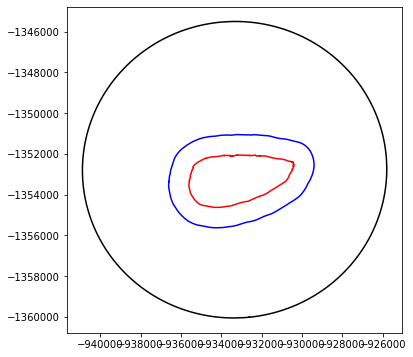

In [23]:
plt.figure(figsize=(6,6))
# plot the marine park outline
plt.plot(*marine_poly.exterior.xy, 'k');
# plot the island outline
plt.plot(*shape(island_geom).exterior.xy, color='red');
# plot the buffer outline
plt.plot(*buffered_island.exterior.xy, color='blue');

## Build query and load data

We will calculate the time taken to load the data as well.

In [24]:
query = {'geopolygon': buffered_marine_geom,
         'output_crs': output_crs,
         'resolution': resolution
         }

Here we do not specify a time parameter, meaning that all available observations will be returned.

If you want to load data for a long time period, you need to keep the bounding box for the query very small. Conversely, if you load a large area, you need to keep the time period short. This is to limit the amount of data that is loaded into memory at any one time.

In [25]:
time1 = datetime.now()
MODIS_data = dc.load(product='modis_oc_1d', measurements=(['sst']), **query)
time2 = datetime.now()
diff = time2 - time1
print('took',diff, 'to finish')

took 0:15:46.987754 to finish


### Create a mask for the area covered by the erased marine park polygon

We only want to keep data within the `buffered_marine_geom`, so we create a mask and remove any data outside this region, and any no-data values from the MODIS data.

In [117]:
mask = rasterio.features.geometry_mask([buffered_marine_geom.to_crs(MODIS_data.geobox.crs) for geoms in [buffered_marine_geom]],
                                           out_shape=MODIS_data.geobox.shape,
                                           transform=MODIS_data.geobox.affine,
                                           all_touched=False,
                                           invert=True)
MODIS_data = MODIS_data.where(mask)
MODIS_data_cleaned = mask_invalid_data(MODIS_data)

### Check the loaded MODIS SST data

Note the extensive time dimension.

In [28]:
MODIS_data_cleaned

<xarray.Dataset>
Dimensions:  (time: 6214, x: 12, y: 13)
Coordinates:
  * time     (time) datetime64[ns] 2002-07-04T11:59:59.999999 ... 2019-07-22T11:59:59.999999
  * y        (y) float64 -1.345e+06 -1.346e+06 ... -1.359e+06 -1.36e+06
  * x        (x) float64 -9.406e+05 -9.392e+05 ... -9.276e+05 -9.262e+05
Data variables:
    sst      (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    crs:      EPSG:3577

### Plot a daily SST image
A quick check of the loaded data

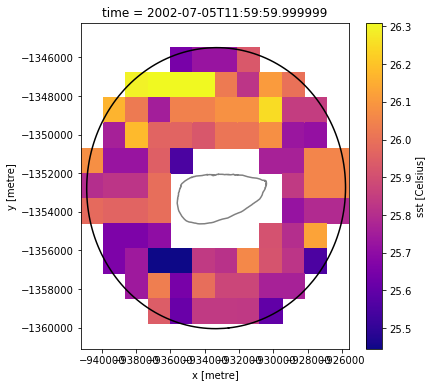

In [57]:
plt.figure(figsize=(6,6))
# plot the marine park outline
plt.plot(*marine_poly.exterior.xy, 'k');
# plot the island outline
plt.plot(*shape(island_geom).exterior.xy, color='gray');
# plot the SST image
MODIS_data_cleaned.sst[1].plot(cmap='plasma');

## Calculate some zonal statistics

We want to get a timeseries of SST for the marine park based on the mean/max/min of all pixels.

In [230]:
MODIS_data_cleaned['sst_mean'] = MODIS_data_cleaned.sst.mean(dim=['x','y'])
MODIS_data_cleaned['sst_min'] = MODIS_data_cleaned.sst.min(dim=['x','y'])
MODIS_data_cleaned['sst_max'] = MODIS_data_cleaned.sst.max(dim=['x','y'])
MODIS_data_cleaned['sst_std'] = MODIS_data_cleaned.sst.std(dim=['x','y'])

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [119]:
MODIS_data_cleaned

<xarray.Dataset>
Dimensions:   (time: 6214, x: 12, y: 13)
Coordinates:
  * time      (time) datetime64[ns] 2002-07-04T11:59:59.999999 ... 2019-07-22T11:59:59.999999
  * y         (y) float64 -1.345e+06 -1.346e+06 ... -1.359e+06 -1.36e+06
  * x         (x) float64 -9.406e+05 -9.392e+05 ... -9.276e+05 -9.262e+05
Data variables:
    sst       (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    sst_mean  (time) float32 26.90471 25.888292 26.697035 ... 26.318197 nan
    sst_min   (time) float32 26.605 25.445 26.38 nan ... 26.64 26.35 25.965 nan
    sst_max   (time) float32 27.145 26.31 27.03 nan ... 27.29 26.35 26.635 nan
Attributes:
    crs:      EPSG:3577

### Plot the mean SST over all available time

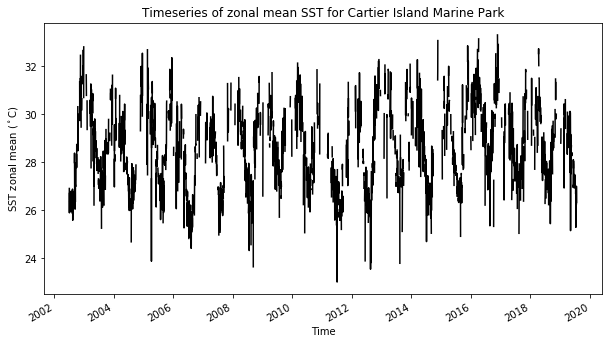

In [108]:
plt.figure(figsize=(10,5))
MODIS_data_cleaned.sst_mean.plot(color='k');
plt.xlabel('Time');
plt.ylabel('SST zonal mean ($^\circ$C)');
plt.title('Timeseries of zonal mean SST for Cartier Island Marine Park');

## Apply interpolation using the pad function to the daily mean, min, max and std SST time-series

In [255]:
MODIS_data_cleaned['sst_mean_interp'] = xr.DataArray(pad(MODIS_data_cleaned['sst_mean'].values,maxPadLength=False), 
                                                     dims='time', coords={'time': MODIS_data_cleaned['time']})
MODIS_data_cleaned['sst_min_interp'] = xr.DataArray(pad(MODIS_data_cleaned['sst_min'].values,maxPadLength=False), 
                                                    dims='time', coords={'time': MODIS_data_cleaned['time']})
MODIS_data_cleaned['sst_max_interp'] = xr.DataArray(pad(MODIS_data_cleaned['sst_max'].values,maxPadLength=False), 
                                                    dims='time', coords={'time': MODIS_data_cleaned['time']})
MODIS_data_cleaned['sst_std_interp'] = xr.DataArray(pad(MODIS_data_cleaned['sst_std'].values,maxPadLength=False), 
                                                    dims='time', coords={'time': MODIS_data_cleaned['time']})

In [256]:
MODIS_data_cleaned

<xarray.Dataset>
Dimensions:          (time: 6214, x: 12, y: 13)
Coordinates:
  * time             (time) datetime64[ns] 2002-07-04T11:59:59.999999 ... 2019-07-22T11:59:59.999999
  * y                (y) float64 -1.345e+06 -1.346e+06 ... -1.359e+06 -1.36e+06
  * x                (x) float64 -9.406e+05 -9.392e+05 ... -9.276e+05 -9.262e+05
Data variables:
    sst              (time, y, x) float32 nan nan nan nan ... nan nan nan nan
    sst_mean         (time) float32 26.90471 25.888292 ... 26.318197 nan
    sst_min          (time) float32 26.605 25.445 26.38 nan ... 26.35 25.965 nan
    sst_max          (time) float32 27.145 26.31 27.03 nan ... 26.35 26.635 nan
    sst_mean_interp  (time) float32 26.90471 25.888292 ... 26.318197 26.318197
    sst_min_interp   (time) float32 26.605 25.445 26.38 ... 26.35 25.965 25.965
    sst_max_interp   (time) float32 27.145 26.31 27.03 ... 26.35 26.635 26.635
    sst_std          (time) float32 0.13803934 0.19083802 ... 0.13774747 nan
    sst_std_interp   (time) float32 0.13803934 0.19083802 ... 0.13774747
Attributes:
    crs:      EPSG:3577

### Plot the interploated daily SST mean, minimum and maximum time-series

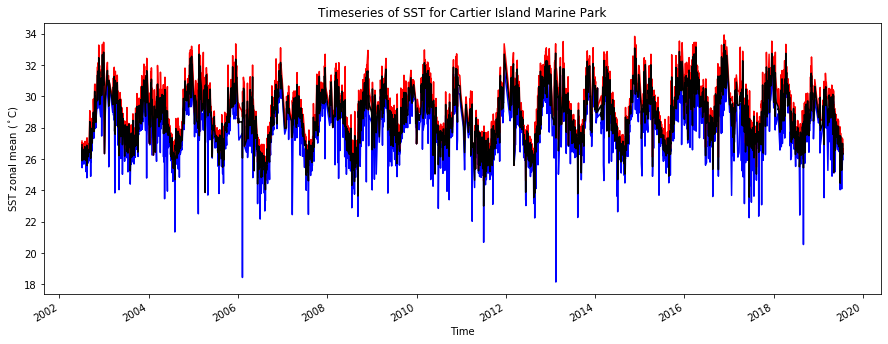

In [124]:
plt.figure(figsize=(15,5))
MODIS_data_cleaned.sst_min_interp.plot(color='b');
MODIS_data_cleaned.sst_max_interp.plot(color='r');
MODIS_data_cleaned.sst_mean_interp.plot(color='k');
plt.xlabel('Time');
plt.ylabel('SST zonal mean ($^\circ$C)');
plt.title('Timeseries of SST for Cartier Island Marine Park');

## Calculate SST monthly, seaonal and yearly time-series, and annual warming rates

### Fit a linear trend line to the interpolated daily mean SST time-series

The slope indicates the daily warming rate. Note that the `sm.ols` function requires the data to apply the fit to as one input, and an index associated with that data as the other, not the actual `time` variable. To achieve this, we input `range(1,len(time)+1)`. Note that it's `+1` as the interp drops one time step, so we need to add an extra index to the input.  

In [200]:
# Applies an ordinary least squares regression
meanFit_daily = sm.ols(formula='sst_mean_interp.values ~ range(1,len(time)+1)',
                 data=MODIS_data_cleaned).fit()
print(meanFit_daily.summary())

                              OLS Regression Results                              
Dep. Variable:     sst_mean_interp.values   R-squared:                       0.012
Model:                                OLS   Adj. R-squared:                  0.012
Method:                     Least Squares   F-statistic:                     76.07
Date:                    Mon, 04 May 2020   Prob (F-statistic):           3.47e-18
Time:                            14:27:40   Log-Likelihood:                -11699.
No. Observations:                    6214   AIC:                         2.340e+04
Df Residuals:                        6212   BIC:                         2.342e+04
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

#### Plot the data with the calculated trendline

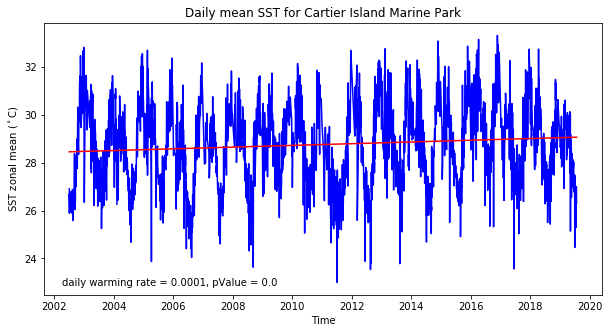

In [202]:
# Fit the trendline to the data
predict_daily = meanFit_daily.predict(MODIS_data_cleaned)

# obtain the warming rate (slope of the trend line) and pValue (indication of the statistical significance)
rate = round(meanFit_daily.params[1], 4)
pValue = round(meanFit_daily.pvalues[1], 4)

ax = plt.figure(figsize=(10, 5))
plt.plot(MODIS_data_cleaned.time, MODIS_data_cleaned.sst_mean_interp, 'b')
plt.plot(MODIS_data_cleaned.time, predict_daily, 'r')

ax.text(0.15,
        0.15,
        f'daily warming rate = {str(rate)}, pValue = {str(pValue)}',
        fontsize=10)

plt.xlabel('Time')
plt.ylabel('SST zonal mean ($^\circ$C)')
plt.title('Daily mean SST for Cartier Island Marine Park');

### Plot and fit a linear trend line to the mean annual time-series

The warming rate calculated is the annual warming rate. Note that the years 2002 and 2019 are partial years and should be excluded.

In [373]:
MODIS_annual_mean_sst = MODIS_data_cleaned.sst_mean.groupby('time.year').mean()

Drop off the partial years 2002 and 2019

In [374]:
MODIS_annual_mean_sst = MODIS_annual_mean_sst[1:-1]

In [375]:
MODIS_annual_mean_sst

<xarray.DataArray 'sst_mean' (year: 16)>
array([28.409729, 28.246294, 28.654387, 27.697483, 28.20303 , 28.257544,
       28.774637, 28.807823, 27.229511, 28.272694, 28.808453, 28.675219,
       28.663666, 29.78649 , 28.509794, 28.619114], dtype=float32)
Coordinates:
  * year     (year) int64 2003 2004 2005 2006 2007 ... 2014 2015 2016 2017 2018

#### Fit a linear trend line to the interpolated daily mean SST time-series

The slope indicates the annual warming rate. 

In [376]:
# Applies an ordinary least squares regression
meanFit_annual = sm.ols(formula='MODIS_annual_mean_sst.values ~ range(1,len(year)+1)',
                 data=MODIS_annual_mean_sst).fit()
print(meanFit_annual.summary())

                                 OLS Regression Results                                 
Dep. Variable:     MODIS_annual_mean_sst.values   R-squared:                       0.153
Model:                                      OLS   Adj. R-squared:                  0.092
Method:                           Least Squares   F-statistic:                     2.523
Date:                          Mon, 04 May 2020   Prob (F-statistic):              0.135
Time:                                  16:47:57   Log-Likelihood:                -11.293
No. Observations:                            16   AIC:                             26.59
Df Residuals:                                14   BIC:                             28.13
Df Model:                                     1                                         
Covariance Type:                      nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
------------------

#### Plot the data with the calculated trendline

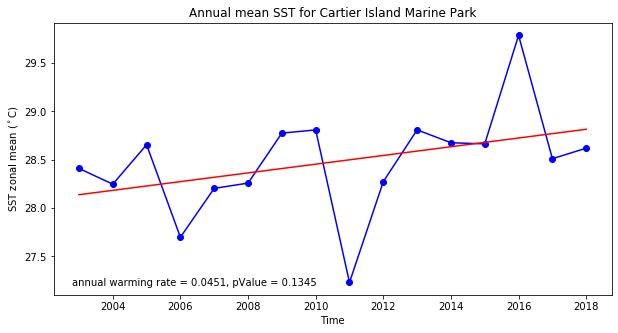

In [377]:
# Fit the trendline to the data
predict_annual = meanFit_annual.predict(MODIS_annual_mean_sst)

# obtain the warming rate (slope of the trend line) and pValue (indication of the statistical significance)
rate = round(meanFit_annual.params[1], 4)
pValue = round(meanFit_annual.pvalues[1], 4)

ax = plt.figure(figsize=(10, 5))
plt.plot(MODIS_annual_mean_sst.year, MODIS_annual_mean_sst, '-ob')
plt.plot(MODIS_annual_mean_sst.year, predict_annual, 'r')

ax.text(0.15,
        0.15,
        f'annual warming rate = {str(rate)}, pValue = {str(pValue)}',
        fontsize=10)

plt.xlabel('Time')
plt.ylabel('SST zonal mean ($^\circ$C)')
plt.title('Annual mean SST for Cartier Island Marine Park');

## Plot annual mean SST with temporal variance and mean spatial variance as error bars

Here, the temporal mean is std of 365 daily mean SST values. The spatial mean is the mean of 365 daily std SST values.

In [246]:
spatial_mean_ann = MODIS_data_cleaned.sst_std.groupby('time.year').mean()
temporal_mean_ann = MODIS_data_cleaned.sst_mean.groupby('time.year').std()

Drop off the partial years 2002 and 2019

In [241]:
temporal_mean_ann = temporal_mean_ann[1:-1]
spatial_mean_ann = spatial_mean_ann[1:-1]

In [242]:
spatial_mean_ann

<xarray.DataArray 'sst_std' (year: 16)>
array([0.2682413 , 0.2713386 , 0.27264386, 0.27975175, 0.25326794,
       0.27815685, 0.26757753, 0.2972777 , 0.25472996, 0.2663384 ,
       0.29705596, 0.2826408 , 0.2698    , 0.27999485, 0.31489384,
       0.26519   ], dtype=float32)
Coordinates:
  * year     (year) int64 2003 2004 2005 2006 2007 ... 2014 2015 2016 2017 2018

#### Plot the data with the error bars

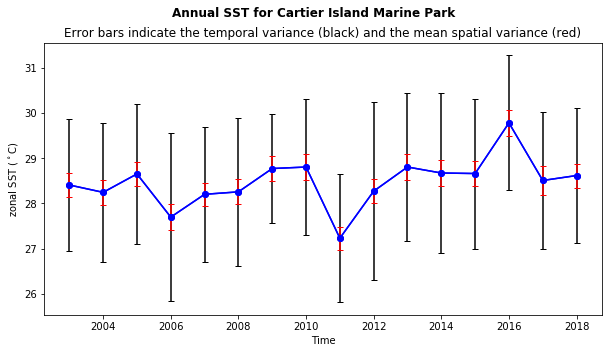

In [244]:
ax = plt.figure(figsize=(10, 5))
plt.errorbar(MODIS_annual_std_sst.year, MODIS_annual_mean_sst, yerr= temporal_mean_ann, 
             ecolor='k', capsize=3, color='b', marker='o')
plt.errorbar(MODIS_annual_std_sst.year, MODIS_annual_mean_sst, yerr= spatial_mean_ann, 
             ecolor='r', capsize=3, color='b', marker='o')
plt.xlabel('Time')
plt.ylabel('zonal SST ($^\circ$C)')
plt.suptitle('Annual SST for Cartier Island Marine Park', fontweight='bold');
plt.title('Error bars indicate the temporal variance (black) and the mean spatial variance (red)');

### Now do the same for the monthly data

In [250]:
# Calculate the monthly mean SST
MODIS_monthly_mean_sst = MODIS_data_cleaned.sst_mean.groupby('time.month').mean()

spatial_mean_mon = MODIS_data_cleaned.sst_std.groupby('time.month').mean()
temporal_mean_mon = MODIS_data_cleaned.sst_mean.groupby('time.month').std()

In [251]:
spatial_mean_mon

<xarray.DataArray 'sst_std' (month: 12)>
array([0.34681347, 0.37556747, 0.38139102, 0.30145216, 0.26598832,
       0.23065831, 0.21531703, 0.21211164, 0.26840338, 0.26325682,
       0.30450162, 0.35845846], dtype=float32)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

#### Plot the data with the std error bars

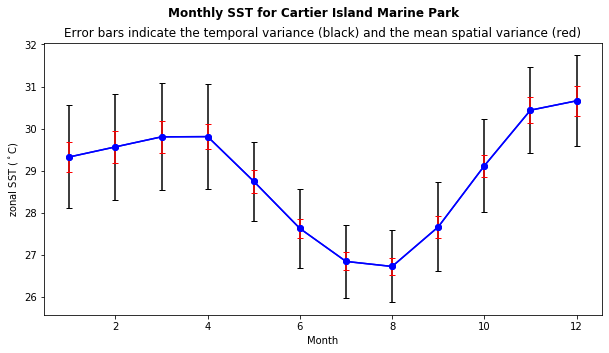

In [254]:
ax = plt.figure(figsize=(10, 5))
plt.errorbar(MODIS_monthly_mean_sst.month, MODIS_monthly_mean_sst, yerr= temporal_mean_mon, 
             ecolor='k', capsize=3, color='b', marker='o')
plt.errorbar(MODIS_monthly_mean_sst.month, MODIS_monthly_mean_sst, yerr= spatial_mean_mon, 
             ecolor='r', capsize=3, color='b', marker='o')
plt.xlabel('Month')
plt.ylabel('zonal SST ($^\circ$C)')
plt.suptitle('Monthly SST for Cartier Island Marine Park', fontweight='bold');
plt.title('Error bars indicate the temporal variance (black) and the mean spatial variance (red)');

## Calculate annual time-series of seasonal statistics (mean, std, etc) using the interpolated data

Here we are using the 3 monthly mean values of zonal mean, interpolated SST to aggregate to seasonal values for each year. 

In [333]:
# Resample into 3 monthly/seasonal means
MODIS_season_mean_sst = MODIS_data_cleaned.sst_mean_interp.resample(time='QS-DEC', label='left').mean()

The first season in 2002 and the last season in 2019 are not complete and should be excluded

In [336]:
MODIS_season_mean_sst = MODIS_season_mean_sst[1:-1]

Now tag each month with the season it belongs to: 1 = summer, 2 = autumn, 3 = winter, 4 = spring

In [337]:
MODIS_season_mean_sst['season'] = (MODIS_season_mean_sst.time.dt.month%12 + 3)//3

In [338]:
MODIS_season_mean_sst

<xarray.DataArray 'sst_mean_interp' (time: 67)>
array([28.932129, 30.441813, 29.288826, 27.17374 , 28.48219 , 29.005634,
       29.094885, 26.898941, 28.815432, 29.974623, 29.515884, 27.249756,
       28.913078, 29.156872, 28.458315, 25.891735, 28.571228, 29.597233,
       28.816805, 26.74913 , 28.825346, 29.575447, 29.428766, 26.568405,
       29.231552, 28.923   , 29.519238, 27.679817, 29.490808, 29.401619,
       29.725742, 27.509054, 28.89197 , 29.112583, 27.398083, 26.263237,
       28.072697, 30.662018, 28.894367, 26.356575, 29.521008, 30.407696,
       29.454065, 27.619404, 29.026451, 29.561014, 29.975769, 27.083546,
       29.189953, 29.946262, 29.329775, 27.115736, 29.438936, 30.252216,
       30.618607, 28.444473, 30.07172 , 29.778172, 29.385714, 27.222858,
       29.123383, 30.143373, 29.800318, 27.273188, 28.799276, 29.139412,
       29.044249], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2002-09-01 2002-12-01 ... 2019-03-01
    season   (time) int64 4 1 2 3 4 1 2 3 4 1 2 3 4 ... 3 4 1 2 3 4 1 2 3 4 1 2

#### Fit a linear trend line to the annual time-series of seasonal mean (Spring in this case)

The warming rate is the annual warming rate for the season

In [343]:
MODIS_spring = MODIS_season_mean_sst[MODIS_season_mean_sst.season == 4]

In [344]:
MODIS_spring

<xarray.DataArray 'sst_mean_interp' (time: 17)>
array([28.932129, 28.48219 , 28.815432, 28.913078, 28.571228, 28.825346,
       29.231552, 29.490808, 28.89197 , 28.072697, 29.521008, 29.026451,
       29.189953, 29.438936, 30.07172 , 29.123383, 28.799276],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2002-09-01 2003-09-01 ... 2018-09-01
    season   (time) int64 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4

In [346]:
# Applies an ordinary least squares regression
meanFit_spring = sm.ols(formula='MODIS_spring.values ~ range(1,len(time)+1)',
                 data=MODIS_spring).fit()
print(meanFit_spring.summary())

                             OLS Regression Results                            
Dep. Variable:     MODIS_spring.values   R-squared:                       0.181
Model:                             OLS   Adj. R-squared:                  0.127
Method:                  Least Squares   F-statistic:                     3.319
Date:                 Mon, 04 May 2020   Prob (F-statistic):             0.0885
Time:                         16:30:50   Log-Likelihood:                -8.7188
No. Observations:                   17   AIC:                             21.44
Df Residuals:                       15   BIC:                             23.10
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept       

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))


#### Plot the data with the calculated trendline

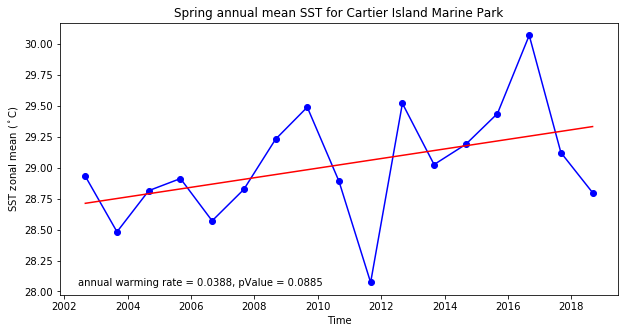

In [370]:
# Fit the trendline to the data
predict_spring = meanFit_spring.predict(MODIS_spring)

# obtain the warming rate (slope of the trend line) and pValue (indication of the statistical significance)
rate = round(meanFit_spring.params[1], 4)
pValue = round(meanFit_spring.pvalues[1], 4)

ax = plt.figure(figsize=(10, 5))
plt.plot(MODIS_spring.time, MODIS_spring, '-ob')
plt.plot(MODIS_spring.time, predict_spring, 'r')

ax.text(0.15,
        0.15,
        f'annual warming rate = {str(rate)}, pValue = {str(pValue)}',
        fontsize=10)

plt.xlabel('Time')
plt.ylabel('SST zonal mean ($^\circ$C)')
plt.title('Spring annual mean SST for Cartier Island Marine Park');

## Identify extreme hot days

A extreme hot day is defined as a day with a SST greater than the 95% percentile of the whole time-series (all days in all years)

In [351]:
# get 95% percentile of the entire time-series
p95 = MODIS_data_cleaned['sst_mean_interp'].quantile(0.95) 

In [355]:
# Find days with a mean zonal SST greater than the 95th percentile
hot_days = MODIS_data_cleaned['sst_mean_interp'][MODIS_data_cleaned['sst_mean_interp'] >= p95]

In [361]:
# Count the number of hot days per year
hot_days_yearly = hot_days.groupby('time.year').count()
# Drop 2002 and 2019 (note that we don't actually have any hot days in 2019)
hot_days_yearly = hot_days_yearly[1:]

In [362]:
hot_days_yearly

<xarray.DataArray 'sst_mean_interp' (year: 16)>
array([ 7, 12,  8,  8,  2, 12,  5, 13, 16, 40, 31, 22, 23, 58, 20, 15])
Coordinates:
    quantile  float64 0.95
  * year      (year) int64 2003 2004 2005 2006 2007 ... 2014 2015 2016 2017 2018

### Plot and fit a linear trend line to the annual time-series of number of extreme hot days

In [363]:
# Applies an ordinary least squares regression
meanFit_hot = sm.ols(formula='hot_days_yearly.values ~ range(1,len(year)+1)',
                 data=hot_days_yearly).fit()
print(meanFit_hot.summary())

                              OLS Regression Results                              
Dep. Variable:     hot_days_yearly.values   R-squared:                       0.366
Model:                                OLS   Adj. R-squared:                  0.320
Method:                     Least Squares   F-statistic:                     8.066
Date:                    Mon, 04 May 2020   Prob (F-statistic):             0.0131
Time:                            16:43:00   Log-Likelihood:                -61.331
No. Observations:                      16   AIC:                             126.7
Df Residuals:                          14   BIC:                             128.2
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))


#### Plot the data with the calculated trendline

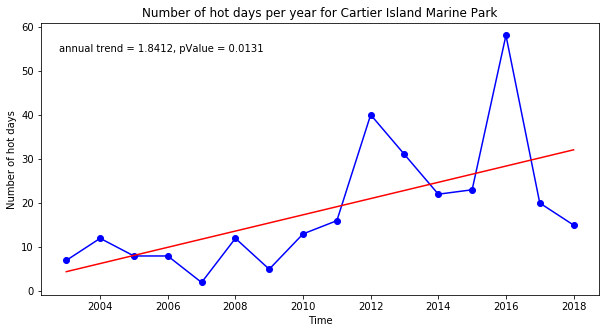

In [369]:
# Fit the trendline to the data
predict_hot = meanFit_hot.predict(hot_days_yearly)

# obtain the warming rate (slope of the trend line) and pValue (indication of the statistical significance)
rate = round(meanFit_hot.params[1], 4)
pValue = round(meanFit_hot.pvalues[1], 4)

ax = plt.figure(figsize=(10, 5))
plt.plot(hot_days_yearly.year, hot_days_yearly, '-ob')
plt.plot(hot_days_yearly.year, predict_hot, 'r')

ax.text(0.15,
        0.8,
        f'annual trend = {str(rate)}, pValue = {str(pValue)}',
        fontsize=10)

plt.xlabel('Time')
plt.ylabel('Number of hot days')
plt.title('Number of hot days per year for Cartier Island Marine Park');

## Calculate per-pixel SST long-term means, seasonal means, monthly means and warming rates

### create a dataframe to contain all per-pixel SST data loaded
156 (12 x 13) locations (as columns) with 6214 daily time-series (as rows)

**latlonDF contains the X, Y coordinates of the locations**

In [31]:
sstDF = pd.DataFrame()
latlonDF = pd.DataFrame()
latList = []
lonList = []
idList = []
latIndex = 0
lonIndex = 0
id = 1
while latIndex < MODIS_data_cleaned.y.size:
    while lonIndex < MODIS_data_cleaned.x.size:
        lat = MODIS_data_cleaned.sst[:,latIndex,lonIndex].y.values
        lon = MODIS_data_cleaned.sst[:,latIndex,lonIndex].x.values
        latList.append(lat)
        lonList.append(lon)
        idList.append(str(id))
        sstData = MODIS_data_cleaned.sst[:,latIndex,lonIndex].values
        sstDF[str(id)] = sstData
        id += 1
        lonIndex += 1
    latIndex += 1
    lonIndex = 0
dateList = []
i = 0
while i < MODIS_data_cleaned.time.size:
    date = str(MODIS_data_cleaned.time[i].data)[:4] + str(MODIS_data_cleaned.time[i].data)[5:7] + str(MODIS_data_cleaned.time[i].data)[8:10]
    dateList.append(date)
    i += 1
sstDF['date'] = dateList
sstDF.set_index('date', inplace=True)
latlonDF['id'] = idList
latlonDF['lat'] = latList
latlonDF['lon'] = lonList
latlonDF.set_index('id', inplace=True)

### calculate per-pixel annual mean SST values

**add year column to the dataframe**

In [32]:
yearList = []
for date in sstDF.index:
    year = date[:4]
    yearList.append(year)
sstDF['year'] = yearList

**The yearSSTDF contains time-series of annual mean SST values for pixels that have at least some valid data**

In [33]:
yearSSTDF = pd.DataFrame()
for col in sstDF.columns:
    if col.isdigit():
        # number of days with valid data (observation); each column is a pixel
        nuData = sstDF.index.size - np.isnan(sstDF[col]).sum()
        if nuData > 0:            
            x = sstDF[col].groupby(sstDF['year']) # groupby year
            xDF = x.describe() # a DataFrame containing the results of the groupby operation
            yearSSTDF[col] = xDF['mean'] # only interest in the mean statistic


**years 2002 and 2019 are partial years and thus should be excluded**

In [34]:
yearSSTDF1 = yearSSTDF.loc['2003':'2018']

### Calculate and display per-pixel annual warming rates

**The yearRateDF contains, for each pixel with some valid data, the warming rate, the number of days with data and the observation frequency within the time-series of the annual mean. A low observation frequency indicates high uncertainty of the warming rate.**

In [35]:
ind = np.arange(1,yearSSTDF1.index.size+1,1)
yearSSTDF1['ind'] = ind
yearRateDF = pd.DataFrame()
idList = []
rateList = []
pValueList = []
for col in yearSSTDF1.columns:    
    if col.isdigit():
        idList.append(col)
        # note the Q() function for the proper handling of the number as a column name
        formula = 'Q("' + col + '")' + ' ~ ind'
        
        fit = sm.ols(formula=formula, data=yearSSTDF1).fit()

        predict = fit.predict(yearSSTDF1)
        yearSSTDF1['fitted'] = predict
        rate = round(fit.params[1],3)
        pValue = round(fit.pvalues[1],2)
        
        rateList.append(rate)
        pValueList.append(pValue)
yearRateDF['id'] = idList
yearRateDF['rate'] = rateList
yearRateDF['pValue'] = pValueList

countList = []
freqList = []
for col in sstDF.columns:
    if col.isdigit():        
        x = sstDF.index.size - np.isnan(sstDF[col]).sum()
        if x > 0:            
            f = x/sstDF.index.size
            countList.append(x)
            freqList.append(f)
yearRateDF['count'] = countList
yearRateDF['frequency'] = freqList
yearRateDF.set_index("id",inplace=True)

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


**add the x and y columns to the yearRateDF**

In [36]:
xList = []
yList = []
for id in yearRateDF.index:
    x = int(latlonDF.loc[id]['lon'])
    y = int(latlonDF.loc[id]['lat'])
    xList.append(x)
    yList.append(y)
yearRateDF['x'] = xList
yearRateDF['y'] = yList

**convert the yearRateDF to an xarray dataset**

In [37]:
yearRateDF1 = yearRateDF.copy()
yearRateDF1.set_index(['y','x'],inplace=True)
yearRateData = xr.Dataset.from_dataframe(yearRateDF1)
yearRateData.attrs['crs']='EPSG:3577'

**display the spatial distribution of the warming rates; the black dots indicate that the pixels have statitically significant warming rates at 85% confidence level**

<Figure size 864x576 with 0 Axes>

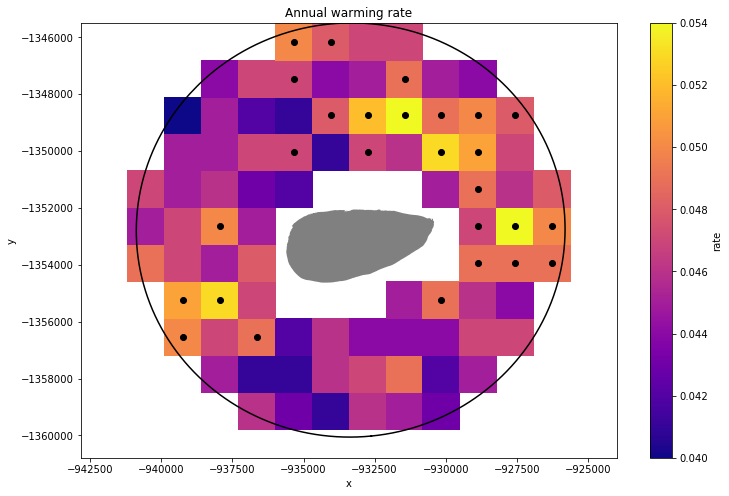

In [38]:
CI = shpf.Reader(AMP_path)

minV = yearRateData['rate'].min()
maxV = yearRateData['rate'].max()

if maxV < 0:
    colormap = 'plasma'
if minV > 0:
    colormap = 'plasma'
if (minV < 0)&(maxV > 0):
    colormap = 'RdYlGn_r'
    minV = max(abs(minV),maxV) * -1
    maxV = max(abs(minV),maxV)
    
plt.figure(figsize=(12,8))
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(figsize=(12,8),color='gray')

yearRateData['rate'].plot(cmap='plasma',vmin=minV,vmax=maxV)
plt.title('Annual warming rate')
plt.axis('equal')
# only highlight data points where pValue <= 0.15, representing significance level >= 85%
tempDF = yearRateDF[yearRateDF['pValue'] <= 0.15]
x = tempDF['x']
y = tempDF['y']

plt.scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')


### Calulate and display per-pixel long-term SST means

**The overallDF contains the long-term mean (std) SST values for each pixel with some valid data**

In [39]:
overallDF = pd.DataFrame()
meanList = []
stdList = []
countList = []
freqList = []
idList = []
for col in sstDF.columns:
    if col.isdigit():        
        x = sstDF.index.size - np.isnan(sstDF[col]).sum()
        if x > 0:        
            sstMean = sstDF[col].mean()
            sstStd = sstDF[col].std()
            f = x/sstDF.index.size
            meanList.append(sstMean)
            stdList.append(sstStd)
            countList.append(x)
            freqList.append(f)
            idList.append(col)
overallDF['id'] = idList
overallDF['mean'] = meanList
overallDF['std'] = stdList
overallDF['count'] = countList
overallDF['frequency'] = freqList
overallDF.set_index('id', inplace=True)

xList = []
yList = []
for id in overallDF.index:
    x = int(latlonDF.loc[id]['lon'])
    y = int(latlonDF.loc[id]['lat'])
    xList.append(x)
    yList.append(y)
overallDF['x'] = xList
overallDF['y'] = yList

**convert the dataframe to an xarray dataset**

In [40]:
overallDF1 = overallDF.copy()
overallDF1.set_index(['y','x'],inplace=True)
overallData = xr.Dataset.from_dataframe(overallDF1)
overallData.attrs['crs']='EPSG:3577'

**plot the spatial distribution of the SST long-term mean; the black dots indicate that the pixels have observation frequency > 30% of the time-series**

<Figure size 864x576 with 0 Axes>

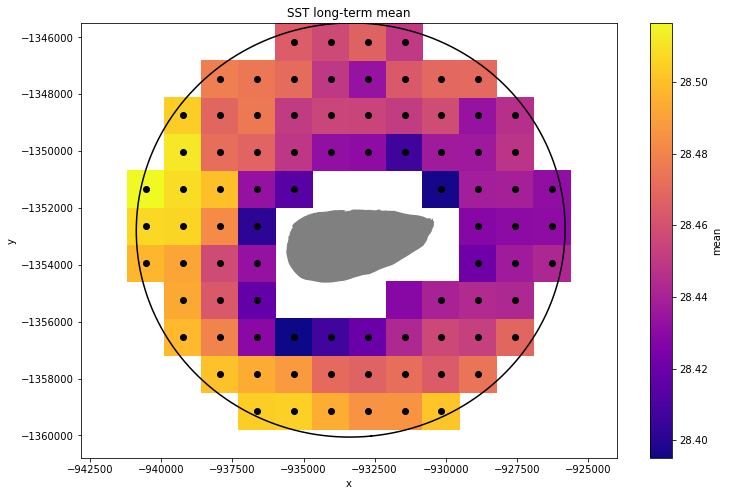

In [41]:
CI = shpf.Reader(AMP_path)
fig = plt.figure(figsize=(12,8))

shape_plot = gpd.read_file(reef_path)
shape_plot.plot(figsize=(12,8),color='gray')
overallData['mean'].plot(cmap='plasma')
for shape in CI.shapeRecords():

    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
plt.axis('equal')
plt.title('SST long-term mean')
# only highlight data points where frequency > 30%
tempDF = overallDF[overallDF['frequency'] > 0.3]
x = tempDF['x']
y = tempDF['y']
plt.scatter(x,y,c='black')


### Calculate and display per-pixel seasonal and monthly SST means

**add season and month columns**

In [42]:
seasonList = []
monthList = []
for date in sstDF.index:
    month = date[4:6]
    monthList.append(month)
    if month in ['12','01','02']:
        season = 'summer'
    elif month in ['03','04','05']:
        season = 'autumn'
    elif month in ['06','07','08']:
        season = 'winter'
    else:
        season = 'spring'
    seasonList.append(season)
sstDF['season'] = seasonList
sstDF['month'] = monthList

**seasonal statistics (e.g., mean, std, etc) for each pixel**

In [43]:
winterSSTDF = pd.DataFrame()
springSSTDF = pd.DataFrame()
summerSSTDF = pd.DataFrame()
autumnSSTDF = pd.DataFrame()
wi_meanList = []
wi_stdList = []
wi_countList = []
wi_freqList = []
sp_meanList = []
sp_stdList = []
sp_countList = []
sp_freqList = []
su_meanList = []
su_stdList = []
su_countList = []
su_freqList = []
au_meanList = []
au_stdList = []
au_countList = []
au_freqList = []

idList = []
for col in sstDF.columns:    
    if col.isdigit():             
        nuData = sstDF.index.size - np.isnan(sstDF[col]).sum()
        if nuData > 0:            
            x = sstDF[col].groupby(sstDF['season']) # groupby season
            xDF = x.describe() # a DataFrame containing the results of the groupby operation
            wi_mean = xDF.loc['winter']['mean']
            wi_std = xDF.loc['winter']['std']
            wi_count = xDF.loc['winter']['count']
            wi_freq = xDF.loc['winter']['count'] / (sstDF['season']=='winter').sum()
            
            sp_mean = xDF.loc['spring']['mean']
            sp_std = xDF.loc['spring']['std']
            sp_count = xDF.loc['spring']['count']
            sp_freq = xDF.loc['spring']['count'] / (sstDF['season']=='spring').sum()
            
            su_mean = xDF.loc['summer']['mean']
            su_std = xDF.loc['summer']['std']
            su_count = xDF.loc['summer']['count']
            su_freq = xDF.loc['summer']['count'] / (sstDF['season']=='summer').sum()
            
            au_mean = xDF.loc['autumn']['mean']
            au_std = xDF.loc['autumn']['std']
            au_count = xDF.loc['autumn']['count']
            au_freq = xDF.loc['autumn']['count'] / (sstDF['season']=='autumn').sum()
            
            idList.append(col)
            
            wi_meanList.append(wi_mean)
            wi_stdList.append(wi_std)
            wi_countList.append(wi_count)
            wi_freqList.append(wi_freq)
            
            sp_meanList.append(sp_mean)
            sp_stdList.append(sp_std)
            sp_countList.append(sp_count)
            sp_freqList.append(sp_freq)
            
            su_meanList.append(su_mean)
            su_stdList.append(su_std)
            su_countList.append(su_count)
            su_freqList.append(su_freq)
            
            au_meanList.append(au_mean)
            au_stdList.append(au_std)
            au_countList.append(au_count)
            au_freqList.append(au_freq)
            
winterSSTDF['id'] = idList
winterSSTDF['mean'] = wi_meanList
winterSSTDF['std'] = wi_stdList
winterSSTDF['count'] = wi_countList
winterSSTDF['frequency'] = wi_freqList
winterSSTDF.set_index('id',inplace=True)

springSSTDF['id'] = idList
springSSTDF['mean'] = sp_meanList
springSSTDF['std'] = sp_stdList
springSSTDF['count'] = sp_countList
springSSTDF['frequency'] = sp_freqList
springSSTDF.set_index('id',inplace=True)

summerSSTDF['id'] = idList
summerSSTDF['mean'] = su_meanList
summerSSTDF['std'] = su_stdList
summerSSTDF['count'] = su_countList
summerSSTDF['frequency'] = su_freqList
summerSSTDF.set_index('id',inplace=True)

autumnSSTDF['id'] = idList
autumnSSTDF['mean'] = au_meanList
autumnSSTDF['std'] = au_stdList
autumnSSTDF['count'] = au_countList
autumnSSTDF['frequency'] = au_freqList
autumnSSTDF.set_index('id',inplace=True)
        

**add x and y to the seasonal dataframes**

In [44]:
xList = []
yList = []
for id in winterSSTDF.index:
    x = int(latlonDF.loc[id]['lon'])
    y = int(latlonDF.loc[id]['lat'])
    xList.append(x)
    yList.append(y)
winterSSTDF['x'] = xList
winterSSTDF['y'] = yList

springSSTDF['x'] = xList
springSSTDF['y'] = yList

summerSSTDF['x'] = xList
summerSSTDF['y'] = yList

autumnSSTDF['x'] = xList
autumnSSTDF['y'] = yList

**convert dataframes to xarry datasets**

In [45]:
winterSSTDF1 = winterSSTDF.copy()
winterSSTDF1.set_index(['y','x'],inplace=True)
winterSSTData = xr.Dataset.from_dataframe(winterSSTDF1)
winterSSTData.attrs['crs']='EPSG:3577'

springSSTDF1 = springSSTDF.copy()
springSSTDF1.set_index(['y','x'],inplace=True)
springSSTData = xr.Dataset.from_dataframe(springSSTDF1)
springSSTData.attrs['crs']='EPSG:3577'

summerSSTDF1 = summerSSTDF.copy()
summerSSTDF1.set_index(['y','x'],inplace=True)
summerSSTData = xr.Dataset.from_dataframe(summerSSTDF1)
summerSSTData.attrs['crs']='EPSG:3577'

autumnSSTDF1 =autumnSSTDF.copy()
autumnSSTDF1.set_index(['y','x'],inplace=True)
autumnSSTData = xr.Dataset.from_dataframe(autumnSSTDF1)
autumnSSTData.attrs['crs']='EPSG:3577'


**display spatial distributions of seasonal mean; the black dots indicate the observation frequency greater than 30%**

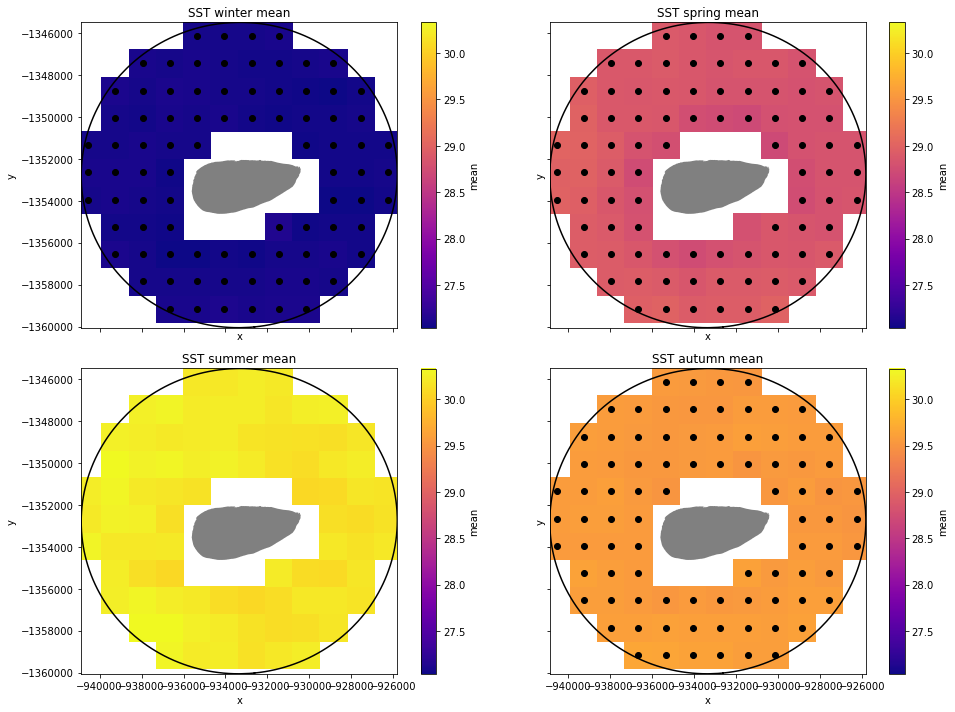

In [48]:

CI = shpf.Reader(AMP_path)
# the following codes obtain the minimum and maximum values in the time-series,
# and use them to set up the colormap
x=[winterSSTData['mean'].min().values,summerSSTData['mean'].min().values,
  springSSTData['mean'].min().values,autumnSSTData['mean'].min().values]
minV = min(x)
x=[winterSSTData['mean'].max().values,summerSSTData['mean'].max().values,
  springSSTData['mean'].max().values,autumnSSTData['mean'].max().values]
maxV = max(x)
if maxV < 0:
    colormap = 'plasma'
if minV > 0:
    colormap = 'plasma'
if (minV < 0)&(maxV > 0):
    colormap = 'RdYlGn_r'
    minV = max(abs(minV),maxV) * -1
    maxV = max(abs(minV),maxV)

# four subplots
f, axes = plt.subplots(2,2,sharex='all',sharey='all',figsize=(14,10))

# winter
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(figsize=(10,10),color='gray',ax=axes[0,0])

winterSSTData['mean'].plot(cmap=colormap,ax=axes[0,0],vmin=minV,vmax=maxV)
axes[0,0].set_title('SST winter mean')

tempDF = winterSSTDF[winterSSTDF['frequency'] >= 0.30]
x = tempDF['x']
y = tempDF['y']

axes[0,0].scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[0,0].plot(x, y, 'k')

# spring
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(figsize=(10,10),color='gray',ax=axes[0,1])
springSSTData['mean'].plot(cmap=colormap,ax=axes[0,1],vmin=minV,vmax=maxV)
axes[0,1].set_title('SST spring mean')

tempDF = springSSTDF[springSSTDF['frequency'] >= 0.30]
x = tempDF['x']
y = tempDF['y']

axes[0,1].scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[0,1].plot(x, y, 'k')

# summer
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(figsize=(10,10),color='gray',ax=axes[1,0])
summerSSTData['mean'].plot(cmap=colormap,ax=axes[1,0],vmin=minV,vmax=maxV)
axes[1,0].set_title('SST summer mean')

tempDF = summerSSTDF[summerSSTDF['frequency'] >= 0.30]
x = tempDF['x']
y = tempDF['y']

axes[1,0].scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[1,0].plot(x, y, 'k')

# autumn
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(figsize=(10,10),color='gray',ax=axes[1,1])
autumnSSTData['mean'].plot(cmap=colormap,ax=axes[1,1],vmin=minV,vmax=maxV)
axes[1,1].set_title('SST autumn mean')

tempDF = autumnSSTDF[autumnSSTDF['frequency'] >= 0.30]
x = tempDF['x']
y = tempDF['y']
axes[1,1].scatter(x,y,c='black')

for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]    
    axes[1,1].plot(x, y, 'k')

xmin = min(x)
xmax = max(x)
ymin = min(y)
ymax = max(y)

axes[0,0].axis([xmin,xmax,ymin,ymax])
f.tight_layout()    
plt.show()

**A conveinent function for calculating SST monthly statistics**

In [49]:
def monthDF(month):
    meanList = []
    stdList = []
    countList = []
    freqList = []
    idList = []
    tempDF = pd.DataFrame()
    for col in sstDF.columns:
        if col.isdigit():
            nuData = sstDF.index.size - np.isnan(sstDF[col]).sum()
            if nuData > 0:            
                x = sstDF[col].groupby(sstDF['month']) # groupby season
                xDF = x.describe() # a DataFrame containing the results of the groupby operation
                mean = xDF.loc[month]['mean']
                std = xDF.loc[month]['std']
                count = xDF.loc[month]['count']
                freq = xDF.loc[month]['count'] / (sstDF['month']==month).sum() 
                idList.append(col)

                meanList.append(mean)
                stdList.append(std)
                countList.append(count)
                freqList.append(freq)
    tempDF['id'] = idList
    tempDF['mean'] = meanList
    tempDF['std'] = stdList
    tempDF['count'] = countList
    tempDF['freq'] = freqList
    tempDF.set_index('id',inplace=True)
    return tempDF

**calculate monthly statistics for each pixel**

In [50]:
JanSSTDF = monthDF('01')
FebSSTDF = monthDF('02')
MarSSTDF = monthDF('03')
AprSSTDF = monthDF('04')
MaySSTDF = monthDF('05')
JunSSTDF = monthDF('06')
JulSSTDF = monthDF('07')
AugSSTDF = monthDF('08')
SepSSTDF = monthDF('09')
OctSSTDF = monthDF('10')
NovSSTDF = monthDF('11')
DecSSTDF = monthDF('12')

**add x and y**

In [51]:
xList = []
yList = []
for id in JanSSTDF.index:
    x = int(latlonDF.loc[id]['lon'])
    y = int(latlonDF.loc[id]['lat'])
    xList.append(x)
    yList.append(y)
JanSSTDF['x'] = xList
JanSSTDF['y'] = yList
FebSSTDF['x'] = xList
FebSSTDF['y'] = yList
MarSSTDF['x'] = xList
MarSSTDF['y'] = yList
AprSSTDF['x'] = xList
AprSSTDF['y'] = yList
MaySSTDF['x'] = xList
MaySSTDF['y'] = yList
JunSSTDF['x'] = xList
JunSSTDF['y'] = yList
JulSSTDF['x'] = xList
JulSSTDF['y'] = yList
AugSSTDF['x'] = xList
AugSSTDF['y'] = yList
SepSSTDF['x'] = xList
SepSSTDF['y'] = yList
OctSSTDF['x'] = xList
OctSSTDF['y'] = yList
NovSSTDF['x'] = xList
NovSSTDF['y'] = yList
DecSSTDF['x'] = xList
DecSSTDF['y'] = yList



**convert to xarray datasets**

In [52]:
JanSSTDF1 = JanSSTDF.copy()
JanSSTDF1.set_index(['y','x'],inplace=True)
JanSSTData = xr.Dataset.from_dataframe(JanSSTDF1)
JanSSTData.attrs['crs']='EPSG:3577'

FebSSTDF1 = FebSSTDF.copy()
FebSSTDF1.set_index(['y','x'],inplace=True)
FebSSTData = xr.Dataset.from_dataframe(FebSSTDF1)
FebSSTData.attrs['crs']='EPSG:3577'

MarSSTDF1 = MarSSTDF.copy()
MarSSTDF1.set_index(['y','x'],inplace=True)
MarSSTData = xr.Dataset.from_dataframe(MarSSTDF1)
MarSSTData.attrs['crs']='EPSG:3577'

AprSSTDF1 = AprSSTDF.copy()
AprSSTDF1.set_index(['y','x'],inplace=True)
AprSSTData = xr.Dataset.from_dataframe(AprSSTDF1)
AprSSTData.attrs['crs']='EPSG:3577'

MaySSTDF1 = MaySSTDF.copy()
MaySSTDF1.set_index(['y','x'],inplace=True)
MaySSTData = xr.Dataset.from_dataframe(MaySSTDF1)
MaySSTData.attrs['crs']='EPSG:3577'

JunSSTDF1 = JunSSTDF.copy()
JunSSTDF1.set_index(['y','x'],inplace=True)
JunSSTData = xr.Dataset.from_dataframe(JunSSTDF1)
JunSSTData.attrs['crs']='EPSG:3577'

JulSSTDF1 = JulSSTDF.copy()
JulSSTDF1.set_index(['y','x'],inplace=True)
JulSSTData = xr.Dataset.from_dataframe(JulSSTDF1)
JulSSTData.attrs['crs']='EPSG:3577'

AugSSTDF1 = AugSSTDF.copy()
AugSSTDF1.set_index(['y','x'],inplace=True)
AugSSTData = xr.Dataset.from_dataframe(AugSSTDF1)
AugSSTData.attrs['crs']='EPSG:3577'

SepSSTDF1 = SepSSTDF.copy()
SepSSTDF1.set_index(['y','x'],inplace=True)
SepSSTData = xr.Dataset.from_dataframe(SepSSTDF1)
SepSSTData.attrs['crs']='EPSG:3577'

OctSSTDF1 = OctSSTDF.copy()
OctSSTDF1.set_index(['y','x'],inplace=True)
OctSSTData = xr.Dataset.from_dataframe(OctSSTDF1)
OctSSTData.attrs['crs']='EPSG:3577'

NovSSTDF1 = NovSSTDF.copy()
NovSSTDF1.set_index(['y','x'],inplace=True)
NovSSTData = xr.Dataset.from_dataframe(NovSSTDF1)
NovSSTData.attrs['crs']='EPSG:3577'

DecSSTDF1 = DecSSTDF.copy()
DecSSTDF1.set_index(['y','x'],inplace=True)
DecSSTData = xr.Dataset.from_dataframe(DecSSTDF1)
DecSSTData.attrs['crs']='EPSG:3577'


**display spatial distributions of SST monthly mean; the black dots indicate observation frequency greater than 30%**

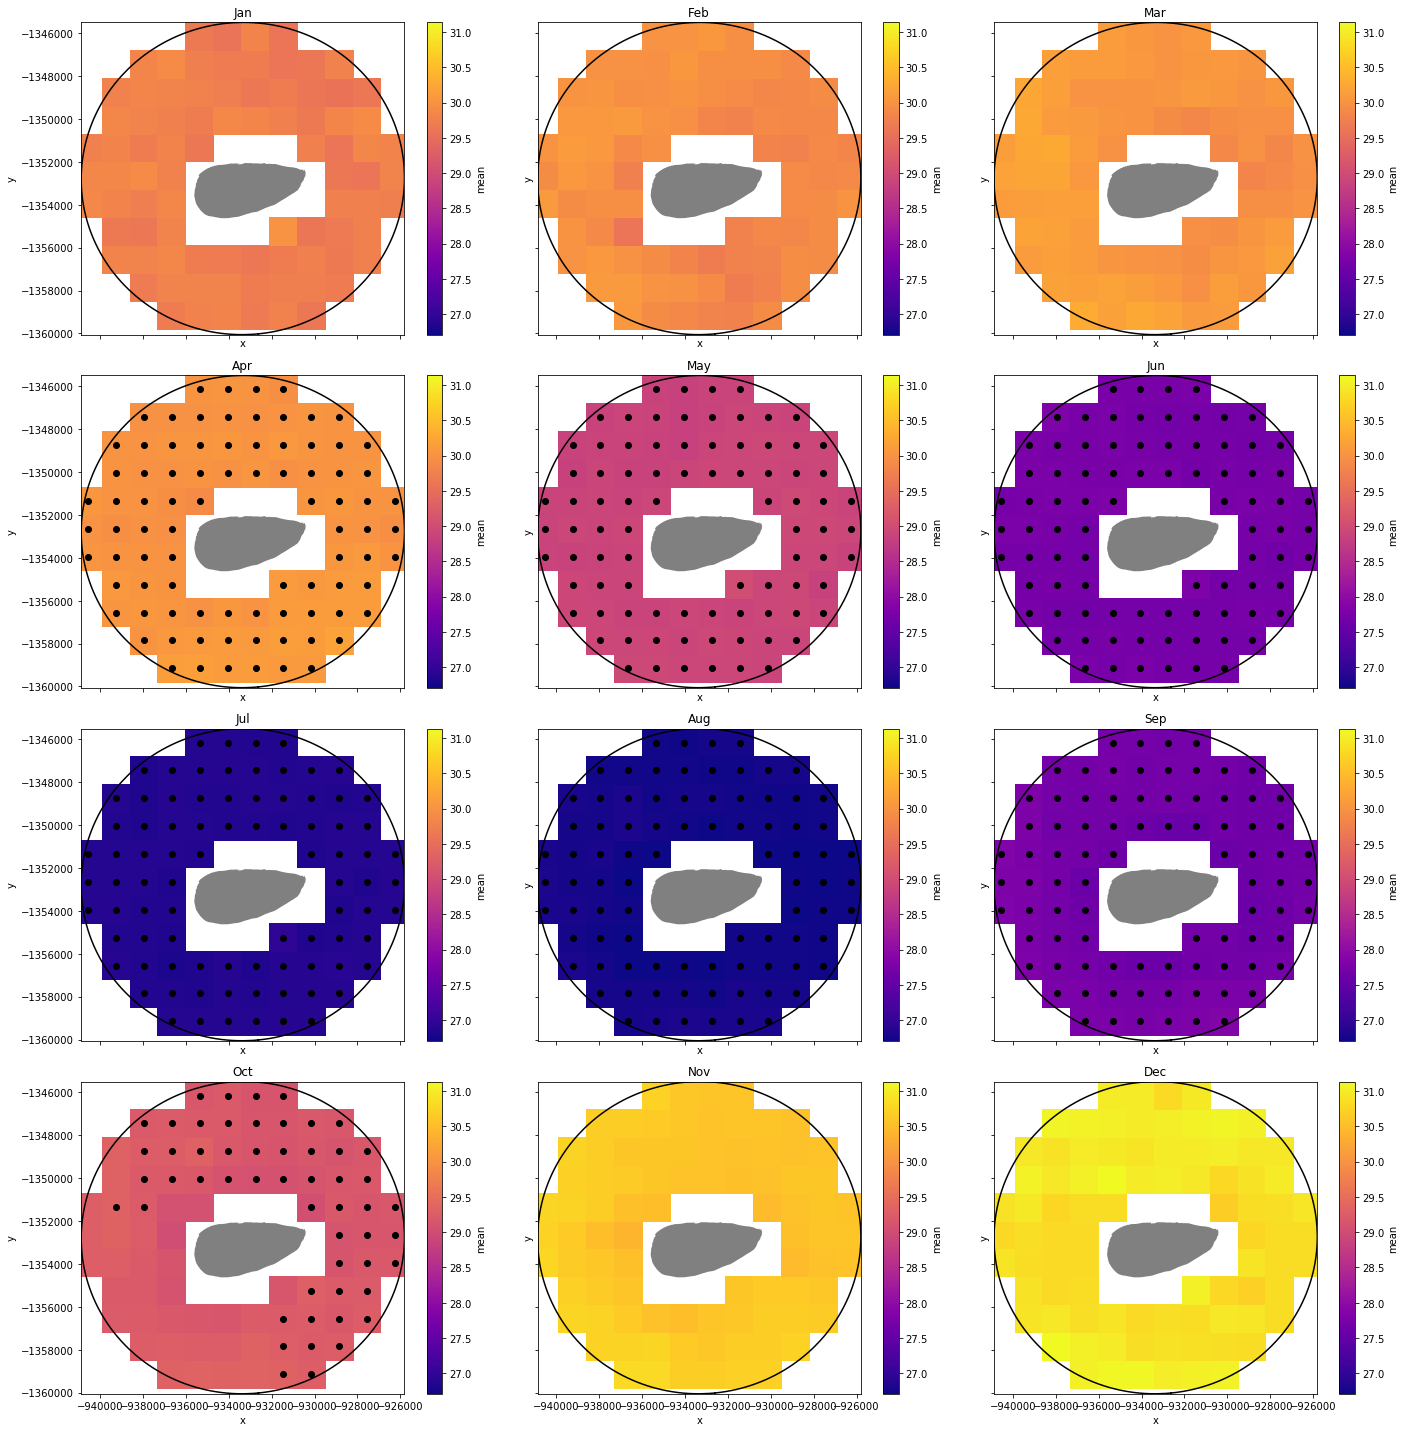

In [53]:

CI = shpf.Reader(AMP_path)

x=[JanSSTData['mean'].min().values,FebSSTData['mean'].min().values,
  MarSSTData['mean'].min().values,AprSSTData['mean'].min().values,
  MaySSTData['mean'].min().values,JunSSTData['mean'].min().values,
  JulSSTData['mean'].min().values,AugSSTData['mean'].min().values,
  SepSSTData['mean'].min().values,OctSSTData['mean'].min().values,
  NovSSTData['mean'].min().values,DecSSTData['mean'].min().values]
minV = min(x)
x=[JanSSTData['mean'].max().values,FebSSTData['mean'].max().values,
  MarSSTData['mean'].max().values,AprSSTData['mean'].max().values,
  MaySSTData['mean'].max().values,JunSSTData['mean'].max().values,
  JulSSTData['mean'].max().values,AugSSTData['mean'].max().values,
  SepSSTData['mean'].max().values,OctSSTData['mean'].max().values,
  NovSSTData['mean'].max().values,DecSSTData['mean'].max().values]
maxV = max(x)
if maxV < 0:
    colormap = 'plasma'
if minV > 0:
    colormap = 'plasma'
if (minV < 0)&(maxV > 0):
    colormap = 'RdYlGn_r'
    minV = max(abs(minV),maxV) * -1
    maxV = max(abs(minV),maxV)

# 12 subplots, four rows, 3 columns, share x and y    
f, axes = plt.subplots(4,3,sharex='all',sharey='all',figsize=(20,20))
# Jan
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[0,0])
JanSSTData['mean'].plot(cmap=colormap,ax=axes[0,0],vmin=minV,vmax=maxV)
axes[0,0].set_title('Jan')
tempDF = JanSSTDF[JanSSTDF['freq'] >= 0.3]
x = tempDF['x']
y = tempDF['y']
axes[0,0].scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[0,0].plot(x, y, 'k')
# Feb
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[0,1])
FebSSTData['mean'].plot(cmap=colormap,ax=axes[0,1],vmin=minV,vmax=maxV)
axes[0,1].set_title('Feb')
tempDF = FebSSTDF[FebSSTDF['freq'] >= 0.3]
x = tempDF['x']
y = tempDF['y']
axes[0,1].scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[0,1].plot(x, y, 'k')
# Mar
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[0,2])
MarSSTData['mean'].plot(cmap=colormap,ax=axes[0,2],vmin=minV,vmax=maxV)
axes[0,2].set_title('Mar')
tempDF = MarSSTDF[MarSSTDF['freq'] >= 0.3]
x = tempDF['x']
y = tempDF['y']
axes[0,2].scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[0,2].plot(x, y, 'k')
# Apr    
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[1,0])
AprSSTData['mean'].plot(cmap=colormap,ax=axes[1,0],vmin=minV,vmax=maxV)
axes[1,0].set_title('Apr')
tempDF = AprSSTDF[AprSSTDF['freq'] >= 0.3]
x = tempDF['x']
y = tempDF['y']
axes[1,0].scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[1,0].plot(x, y, 'k')
# May
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[1,1])
MaySSTData['mean'].plot(cmap=colormap,ax=axes[1,1],vmin=minV,vmax=maxV)
axes[1,1].set_title('May')
tempDF = MaySSTDF[MaySSTDF['freq'] >= 0.3]
x = tempDF['x']
y = tempDF['y']
axes[1,1].scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[1,1].plot(x, y, 'k')
# Jun
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[1,2])
JunSSTData['mean'].plot(cmap=colormap,ax=axes[1,2],vmin=minV,vmax=maxV)
axes[1,2].set_title('Jun')
tempDF = JunSSTDF[JunSSTDF['freq'] >= 0.3]
x = tempDF['x']
y = tempDF['y']
axes[1,2].scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[1,2].plot(x, y, 'k')
# Jul
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[2,0])
JulSSTData['mean'].plot(cmap=colormap,ax=axes[2,0],vmin=minV,vmax=maxV)
axes[2,0].set_title('Jul')
tempDF = JulSSTDF[JulSSTDF['freq'] >= 0.3]
x = tempDF['x']
y = tempDF['y']
axes[2,0].scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[2,0].plot(x, y, 'k')
# Aug   
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[2,1])
AugSSTData['mean'].plot(cmap=colormap,ax=axes[2,1],vmin=minV,vmax=maxV)
axes[2,1].set_title('Aug')
tempDF = AugSSTDF[AugSSTDF['freq'] >= 0.3]
x = tempDF['x']
y = tempDF['y']
axes[2,1].scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[2,1].plot(x, y, 'k')
# Sep
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[2,2])
SepSSTData['mean'].plot(cmap=colormap,ax=axes[2,2],vmin=minV,vmax=maxV)
axes[2,2].set_title('Sep')
tempDF = SepSSTDF[SepSSTDF['freq'] >= 0.3]
x = tempDF['x']
y = tempDF['y']
axes[2,2].scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[2,2].plot(x, y, 'k')
# Oct
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[3,0])
OctSSTData['mean'].plot(cmap=colormap,ax=axes[3,0],vmin=minV,vmax=maxV)
axes[3,0].set_title('Oct')
tempDF = OctSSTDF[OctSSTDF['freq'] >= 0.3]
x = tempDF['x']
y = tempDF['y']
axes[3,0].scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[3,0].plot(x, y, 'k')
# Nov
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[3,1])
NovSSTData['mean'].plot(cmap=colormap,ax=axes[3,1],vmin=minV,vmax=maxV)
axes[3,1].set_title('Nov')
tempDF = NovSSTDF[NovSSTDF['freq'] >= 0.3]
x = tempDF['x']
y = tempDF['y']
axes[3,1].scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[3,1].plot(x, y, 'k')
# Dec
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[3,2])
DecSSTData['mean'].plot(cmap=colormap,ax=axes[3,2],vmin=minV,vmax=maxV)
axes[3,2].set_title('Dec')
tempDF = DecSSTDF[DecSSTDF['freq'] >= 0.3]
x = tempDF['x']
y = tempDF['y']
axes[3,2].scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[3,2].plot(x, y, 'k')
    
xmin = min(x)
xmax = max(x)
ymin = min(y)
ymax = max(y)

axes[0,0].axis([xmin,xmax,ymin,ymax])
f.tight_layout()    
plt.show()

### Calculate the annual warming rates of seasons and months

**function for generating annual time-series of seasonal mean for each pixel with some valid data**

In [54]:
def yearseasonSST(season):
    tempDF = pd.DataFrame()
    for col in sstDF.columns:        
        if col.isdigit():
            # nuData is the number of days in a point time-series with valid data (observation)
            # a point time-series is a pixel drill of the SST data, each pixel is a column in sstDF, 
            nuData = sstDF.index.size - np.isnan(sstDF[col]).sum()
            # pixels without any observation are discarded
            if nuData > 0:
                x = sstDF[sstDF['season'] == season]
                y = x[col].groupby(x['year'])
                
                xDF = y.describe() # a DataFrame containing the results of the groupby operation
                tempDF[col] = xDF['mean'] # only interest in the mean statists
                
    return tempDF

In [55]:
yearwinterDF = yearseasonSST('winter')
yearspringDF = yearseasonSST('spring')
yearsummerDF = yearseasonSST('summer')
yearautumnDF = yearseasonSST('autumn')

In [56]:
# years 2002 and 2019 do not contain a full summer season
# summer months 12, 1 and 2 expand two years, this is another issue
yearsummerDF1 = yearsummerDF.loc['2003':'2018']

**function for calculating warming rates of annual time-series of seasonal mean for each pixel with some valid data**

In [57]:
def yearseasonTrend(yearseasonDF,season):
    ind = np.arange(1,yearseasonDF.index.size+1,1)
    yearseasonDF['ind'] = ind
    yearseasonRateDF = pd.DataFrame()
    idList = []
    rateList = []
    pValueList = []
    for col in yearseasonDF.columns:        
        if col.isdigit():
            idList.append(col)
            x = yearseasonDF.index.size - np.isnan(yearseasonDF[col]).sum()
            f = x/yearseasonDF.index.size
            # only calculate warming rate if having more than 50% of valid data
            if f > 0.5:                
                # note the Q() function for the proper handling of the number as a column name
                formula = 'Q("' + col + '")' + ' ~ ind'

                fit = sm.ols(formula=formula, data=yearseasonDF, missing='drop').fit()

                predict = fit.predict(yearseasonDF)
                yearseasonDF['fitted'] = predict
                rate = round(fit.params[1],3)
                pValue = round(fit.pvalues[1],2)
            else:
                rate = np.nan
                pValue = np.nan

            rateList.append(rate)
            pValueList.append(pValue)
        else:
            break
    yearseasonRateDF['id'] = idList
    yearseasonRateDF['rate'] = rateList
    yearseasonRateDF['pValue'] = pValueList

    countList = []
    freqList = []
    tempDF = sstDF[sstDF['season'] == season]
    # calculate frequency values
    for col in yearseasonDF.columns:
        
        if col.isdigit():        
            x = tempDF.index.size - np.isnan(tempDF[col]).sum()
            f = x/tempDF.index.size
           
            countList.append(x)
            freqList.append(f)
        else:
            break
    yearseasonRateDF['count'] = countList
    yearseasonRateDF['frequency'] = freqList
    yearseasonRateDF.set_index("id",inplace=True)
    
    return yearseasonRateDF

In [58]:
yearwinterRateDF = yearseasonTrend(yearwinterDF,'winter')
yearspringRateDF = yearseasonTrend(yearspringDF,'spring')
yearsummerRateDF = yearseasonTrend(yearsummerDF1,'summer')
yearautumnRateDF = yearseasonTrend(yearautumnDF,'autumn')

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


**add x and y columns**

In [59]:
xList = []
yList = []
for id in yearsummerRateDF.index:
    x = int(latlonDF.loc[id]['lon'])
    y = int(latlonDF.loc[id]['lat'])
    xList.append(x)
    yList.append(y)
yearsummerRateDF['x'] = xList
yearsummerRateDF['y'] = yList
yearspringRateDF['x'] = xList
yearspringRateDF['y'] = yList
yearautumnRateDF['x'] = xList
yearautumnRateDF['y'] = yList
yearwinterRateDF['x'] = xList
yearwinterRateDF['y'] = yList


**convert to xarray datasets**

In [60]:
yearsummerRateDF1 = yearsummerRateDF.copy()
yearsummerRateDF1.set_index(['y','x'],inplace=True)
yearsummerRateData = xr.Dataset.from_dataframe(yearsummerRateDF1)
yearsummerRateData.attrs['crs']='EPSG:3577'

yearspringRateDF1 = yearspringRateDF.copy()
yearspringRateDF1.set_index(['y','x'],inplace=True)
yearspringRateData = xr.Dataset.from_dataframe(yearspringRateDF1)
yearspringRateData.attrs['crs']='EPSG:3577'

yearautumnRateDF1 = yearautumnRateDF.copy()
yearautumnRateDF1.set_index(['y','x'],inplace=True)
yearautumnRateData = xr.Dataset.from_dataframe(yearautumnRateDF1)
yearautumnRateData.attrs['crs']='EPSG:3577'

yearwinterRateDF1 = yearwinterRateDF.copy()
yearwinterRateDF1.set_index(['y','x'],inplace=True)
yearwinterRateData = xr.Dataset.from_dataframe(yearwinterRateDF1)
yearwinterRateData.attrs['crs']='EPSG:3577'


**display spatial patterns of annual warming rates of seasonal means; the black dots indicate statistical signficance at 90% confidence level**

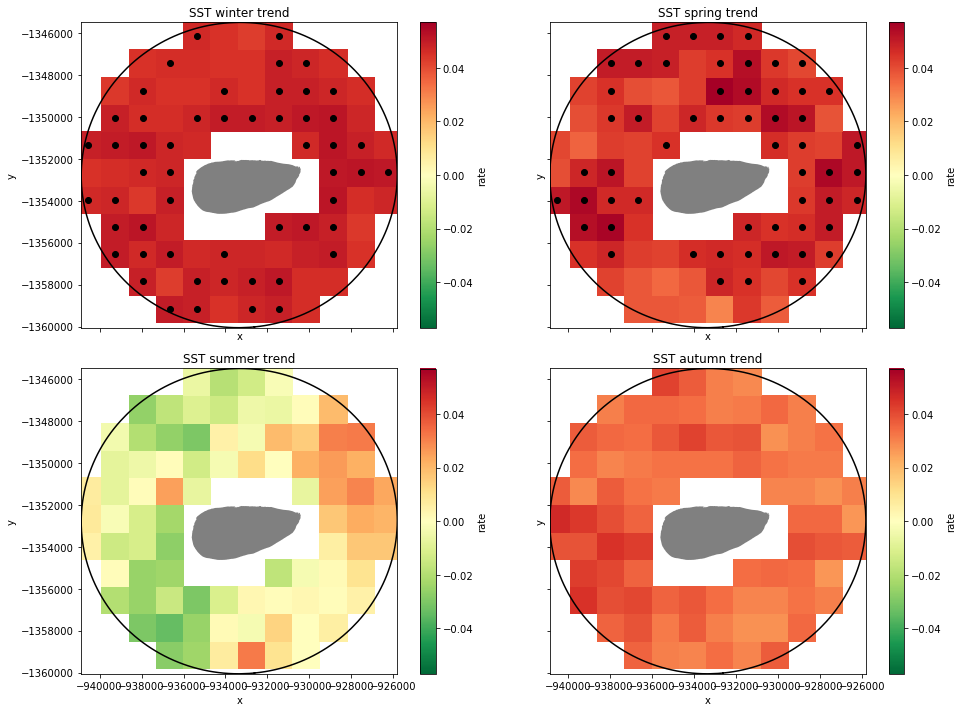

In [61]:

CI = shpf.Reader(AMP_path)

x=[yearwinterRateData['rate'].min().values,yearsummerRateData['rate'].min().values,
  yearspringRateData['rate'].min().values,yearautumnRateData['rate'].min().values]
minV = min(x)
x=[yearwinterRateData['rate'].max().values,yearsummerRateData['rate'].max().values,
  yearspringRateData['rate'].max().values,yearautumnRateData['rate'].max().values]
maxV = max(x)
if maxV < 0:
    colormap = 'YlGn'
if minV > 0:
    colormap = 'YlGn'
if (minV < 0)&(maxV > 0):
    colormap = 'RdYlGn_r'
    minV = max(abs(minV),maxV) * -1
    maxV = max(abs(minV),maxV)


f, axes = plt.subplots(2,2,sharex='all',sharey='all',figsize=(14,10))

# winter
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(figsize=(10,10),color='gray',ax=axes[0,0])

yearwinterRateData['rate'].plot(cmap=colormap,ax=axes[0,0],vmin=minV,vmax=maxV)
axes[0,0].set_title('SST winter trend')

tempDF = yearwinterRateDF[yearwinterRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']

axes[0,0].scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[0,0].plot(x, y, 'k')

# spring
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(figsize=(10,10),color='gray',ax=axes[0,1])
yearspringRateData['rate'].plot(cmap=colormap,ax=axes[0,1],vmin=minV,vmax=maxV)
axes[0,1].set_title('SST spring trend')

tempDF = yearspringRateDF[yearspringRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']

axes[0,1].scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[0,1].plot(x, y, 'k')

# summer
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(figsize=(10,10),color='gray',ax=axes[1,0])
yearsummerRateData['rate'].plot(cmap=colormap,ax=axes[1,0],vmin=minV,vmax=maxV)
axes[1,0].set_title('SST summer trend')

tempDF = yearsummerRateDF[yearsummerRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']

axes[1,0].scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[1,0].plot(x, y, 'k')

# autumn
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(figsize=(10,10),color='gray',ax=axes[1,1])
yearautumnRateData['rate'].plot(cmap=colormap,ax=axes[1,1],vmin=minV,vmax=maxV)
axes[1,1].set_title('SST autumn trend')

tempDF = yearautumnRateDF[yearautumnRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
axes[1,1].scatter(x,y,c='black')

for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]    
    axes[1,1].plot(x, y, 'k')

xmin = min(x)
xmax = max(x)
ymin = min(y)
ymax = max(y)

axes[0,0].axis([xmin,xmax,ymin,ymax])
f.tight_layout()    
plt.show()

**function for generating annual time-series of monthly mean for each pixel with some valid data**

In [62]:
def yearmonthSST(month):
    tempDF = pd.DataFrame()
    for col in sstDF.columns:        
        if col.isdigit():            
            nuData = sstDF.index.size - np.isnan(sstDF[col]).sum()
            if nuData > 0:
                x = sstDF[sstDF['month'] == month]
                y = x[col].groupby(x['year'])
                
                xDF = y.describe() # a DataFrame containing the results of the groupby operation
                tempDF[col] = xDF['mean'] # only interest in the mean statists
                
    return tempDF

**function for calculating warming rates of annual time-series of monthly mean for each pixel with some valid data**

In [63]:
import statsmodels.formula.api as sm
def yearmonthTrend(yearmonthDF,month):
    ind = np.arange(1,yearmonthDF.index.size+1,1)
    yearmonthDF['ind'] = ind
    yearmonthRateDF = pd.DataFrame()
    idList = []
    rateList = []
    pValueList = []
    for col in yearmonthDF.columns:
        
        if col.isdigit():
            idList.append(col)
            x = yearmonthDF.index.size - np.isnan(yearmonthDF[col]).sum()
            f = x/yearmonthDF.index.size
            if f > 0.5:                
                # note the Q() function for the proper handling of the number as a column name
                formula = 'Q("' + col + '")' + ' ~ ind'

                fit = sm.ols(formula=formula, data=yearmonthDF, missing='drop').fit()

                predict = fit.predict(yearmonthDF)
                yearmonthDF['fitted'] = predict
                rate = round(fit.params[1],3)
                pValue = round(fit.pvalues[1],2)
            else:
                rate = np.nan
                pValue = np.nan

            rateList.append(rate)
            pValueList.append(pValue)
        else:
            break
    yearmonthRateDF['id'] = idList
    yearmonthRateDF['rate'] = rateList
    yearmonthRateDF['pValue'] = pValueList

    countList = []
    freqList = []
    tempDF = sstDF[sstDF['month'] == month]
    
    for col in yearmonthDF.columns:        
        if col.isdigit():        
            x = tempDF.index.size - np.isnan(tempDF[col]).sum()            
                      
            f = x/tempDF.index.size
           
            countList.append(x)
            freqList.append(f)
        else:
            break
    yearmonthRateDF['count'] = countList
    yearmonthRateDF['frequency'] = freqList
    yearmonthRateDF.set_index("id",inplace=True)
    
    return yearmonthRateDF

**calculate annual time-series of monthly means and their trends**

In [64]:
yearJanDF = yearmonthSST('01')
yearJanRateDF = yearmonthTrend(yearJanDF,'01')
yearFebDF = yearmonthSST('02')
yearFebRateDF = yearmonthTrend(yearFebDF,'02')
yearMarDF = yearmonthSST('03')
yearMarRateDF = yearmonthTrend(yearMarDF,'03')
yearAprDF = yearmonthSST('04')
yearAprRateDF = yearmonthTrend(yearAprDF,'04')
yearMayDF = yearmonthSST('05')
yearMayRateDF = yearmonthTrend(yearMayDF,'05')
yearJunDF = yearmonthSST('06')
yearJunRateDF = yearmonthTrend(yearJunDF,'06')
yearJulDF = yearmonthSST('07')
yearJulRateDF = yearmonthTrend(yearJulDF,'07')
yearAugDF = yearmonthSST('08')
yearAugRateDF = yearmonthTrend(yearAugDF,'08')
yearSepDF = yearmonthSST('09')
yearSepRateDF = yearmonthTrend(yearSepDF,'09')
yearOctDF = yearmonthSST('10')
yearOctRateDF = yearmonthTrend(yearOctDF,'10')
yearNovDF = yearmonthSST('11')
yearNovRateDF = yearmonthTrend(yearNovDF,'11')
yearDecDF = yearmonthSST('12')
yearDecRateDF = yearmonthTrend(yearDecDF,'12')

**add x and y columns**

In [65]:
xList = []
yList = []
for id in yearJanRateDF.index:
    x = int(latlonDF.loc[id]['lon'])
    y = int(latlonDF.loc[id]['lat'])
    xList.append(x)
    yList.append(y)
yearJanRateDF['x'] = xList
yearJanRateDF['y'] = yList
yearFebRateDF['x'] = xList
yearFebRateDF['y'] = yList
yearMarRateDF['x'] = xList
yearMarRateDF['y'] = yList
yearAprRateDF['x'] = xList
yearAprRateDF['y'] = yList
yearMayRateDF['x'] = xList
yearMayRateDF['y'] = yList
yearJunRateDF['x'] = xList
yearJunRateDF['y'] = yList
yearJulRateDF['x'] = xList
yearJulRateDF['y'] = yList
yearAugRateDF['x'] = xList
yearAugRateDF['y'] = yList
yearSepRateDF['x'] = xList
yearSepRateDF['y'] = yList
yearOctRateDF['x'] = xList
yearOctRateDF['y'] = yList
yearNovRateDF['x'] = xList
yearNovRateDF['y'] = yList
yearDecRateDF['x'] = xList
yearDecRateDF['y'] = yList


**convert to xarray datasets**

In [66]:
yearJanRateDF1 = yearJanRateDF.copy()
yearJanRateDF1.set_index(['y','x'],inplace=True)
yearJanRateData = xr.Dataset.from_dataframe(yearJanRateDF1)
yearJanRateData.attrs['crs']='EPSG:3577'

yearFebRateDF1 = yearFebRateDF.copy()
yearFebRateDF1.set_index(['y','x'],inplace=True)
yearFebRateData = xr.Dataset.from_dataframe(yearFebRateDF1)
yearFebRateData.attrs['crs']='EPSG:3577'

yearMarRateDF1 = yearMarRateDF.copy()
yearMarRateDF1.set_index(['y','x'],inplace=True)
yearMarRateData = xr.Dataset.from_dataframe(yearMarRateDF1)
yearMarRateData.attrs['crs']='EPSG:3577'

yearAprRateDF1 = yearAprRateDF.copy()
yearAprRateDF1.set_index(['y','x'],inplace=True)
yearAprRateData = xr.Dataset.from_dataframe(yearAprRateDF1)
yearAprRateData.attrs['crs']='EPSG:3577'

yearMayRateDF1 = yearMayRateDF.copy()
yearMayRateDF1.set_index(['y','x'],inplace=True)
yearMayRateData = xr.Dataset.from_dataframe(yearMayRateDF1)
yearMayRateData.attrs['crs']='EPSG:3577'

yearJunRateDF1 = yearJunRateDF.copy()
yearJunRateDF1.set_index(['y','x'],inplace=True)
yearJunRateData = xr.Dataset.from_dataframe(yearJunRateDF1)
yearJunRateData.attrs['crs']='EPSG:3577'

yearJulRateDF1 = yearJulRateDF.copy()
yearJulRateDF1.set_index(['y','x'],inplace=True)
yearJulRateData = xr.Dataset.from_dataframe(yearJulRateDF1)
yearJulRateData.attrs['crs']='EPSG:3577'

yearAugRateDF1 = yearAugRateDF.copy()
yearAugRateDF1.set_index(['y','x'],inplace=True)
yearAugRateData = xr.Dataset.from_dataframe(yearAugRateDF1)
yearAugRateData.attrs['crs']='EPSG:3577'

yearSepRateDF1 = yearSepRateDF.copy()
yearSepRateDF1.set_index(['y','x'],inplace=True)
yearSepRateData = xr.Dataset.from_dataframe(yearSepRateDF1)
yearSepRateData.attrs['crs']='EPSG:3577'

yearOctRateDF1 = yearOctRateDF.copy()
yearOctRateDF1.set_index(['y','x'],inplace=True)
yearOctRateData = xr.Dataset.from_dataframe(yearOctRateDF1)
yearOctRateData.attrs['crs']='EPSG:3577'

yearNovRateDF1 = yearNovRateDF.copy()
yearNovRateDF1.set_index(['y','x'],inplace=True)
yearNovRateData = xr.Dataset.from_dataframe(yearNovRateDF1)
yearNovRateData.attrs['crs']='EPSG:3577'

yearDecRateDF1 = yearDecRateDF.copy()
yearDecRateDF1.set_index(['y','x'],inplace=True)
yearDecRateData = xr.Dataset.from_dataframe(yearDecRateDF1)
yearDecRateData.attrs['crs']='EPSG:3577'


**display spatial patterns of annual warming rates of monthly means; the black dots indicate statistical signficance at 90% confidence level**

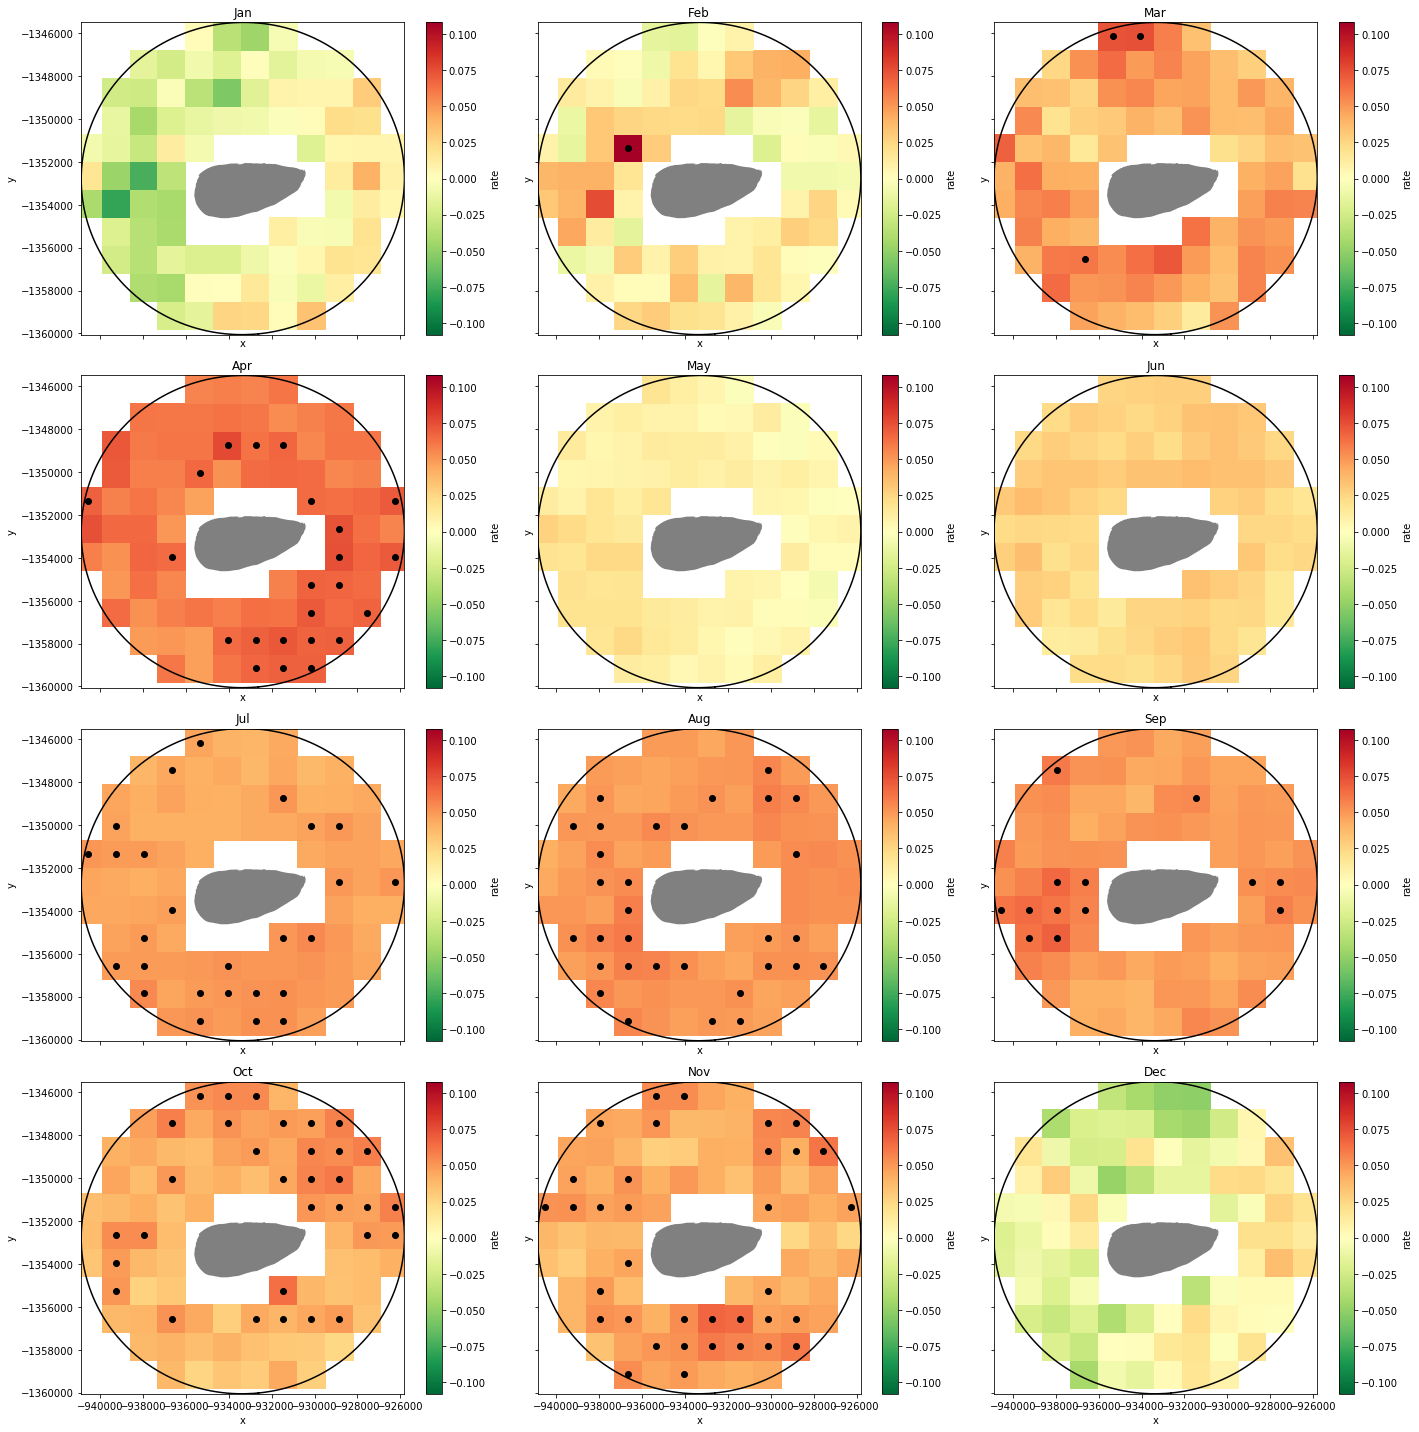

In [67]:

CI = shpf.Reader(AMP_path)

x=[yearJanRateData['rate'].min().values,yearFebRateData['rate'].min().values,
  yearMarRateData['rate'].min().values,yearAprRateData['rate'].min().values,
  yearMayRateData['rate'].min().values,yearJunRateData['rate'].min().values,
  yearJulRateData['rate'].min().values,yearAugRateData['rate'].min().values,
  yearSepRateData['rate'].min().values,yearOctRateData['rate'].min().values,
  yearNovRateData['rate'].min().values,yearDecRateData['rate'].min().values]
minV = min(x)
x=[yearJanRateData['rate'].max().values,yearFebRateData['rate'].max().values,
  yearMarRateData['rate'].max().values,yearAprRateData['rate'].max().values,
  yearMayRateData['rate'].max().values,yearJunRateData['rate'].max().values,
  yearJulRateData['rate'].max().values,yearAugRateData['rate'].max().values,
  yearSepRateData['rate'].max().values,yearOctRateData['rate'].max().values,
  yearNovRateData['rate'].max().values,yearDecRateData['rate'].max().values]
maxV = max(x)
if maxV < 0:
    colormap = 'YlGn'
if minV > 0:
    colormap = 'YlGn'
if (minV < 0)&(maxV > 0):
    colormap = 'RdYlGn_r'
    minV = max(abs(minV),maxV) * -1
    maxV = max(abs(minV),maxV)

    
f, axes = plt.subplots(4,3,sharex='all',sharey='all',figsize=(20,20))
# Jan
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[0,0])
yearJanRateData['rate'].plot(cmap='RdYlGn_r',ax=axes[0,0],vmin=minV,vmax=maxV)
axes[0,0].set_title('Jan')
tempDF = yearJanRateDF[yearJanRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
axes[0,0].scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[0,0].plot(x, y, 'k')
# Feb
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[0,1])
yearFebRateData['rate'].plot(cmap='RdYlGn_r',ax=axes[0,1],vmin=minV,vmax=maxV)
axes[0,1].set_title('Feb')
tempDF = yearFebRateDF[yearFebRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
axes[0,1].scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[0,1].plot(x, y, 'k')
# Mar
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[0,2])
yearMarRateData['rate'].plot(cmap='RdYlGn_r',ax=axes[0,2],vmin=minV,vmax=maxV)
axes[0,2].set_title('Mar')
tempDF = yearMarRateDF[yearMarRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
axes[0,2].scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[0,2].plot(x, y, 'k')
# Apr    
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[1,0])
yearAprRateData['rate'].plot(cmap='RdYlGn_r',ax=axes[1,0],vmin=minV,vmax=maxV)
axes[1,0].set_title('Apr')
tempDF = yearAprRateDF[yearAprRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
axes[1,0].scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[1,0].plot(x, y, 'k')
# May
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[1,1])
yearMayRateData['rate'].plot(cmap='RdYlGn_r',ax=axes[1,1],vmin=minV,vmax=maxV)
axes[1,1].set_title('May')
tempDF = yearMayRateDF[yearMayRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
axes[1,1].scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[1,1].plot(x, y, 'k')
# Jun
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[1,2])
yearJunRateData['rate'].plot(cmap='RdYlGn_r',ax=axes[1,2],vmin=minV,vmax=maxV)
axes[1,2].set_title('Jun')
tempDF = yearJunRateDF[yearJunRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
axes[1,2].scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[1,2].plot(x, y, 'k')
# Jul
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[2,0])
yearJulRateData['rate'].plot(cmap='RdYlGn_r',ax=axes[2,0],vmin=minV,vmax=maxV)
axes[2,0].set_title('Jul')
tempDF = yearJulRateDF[yearJulRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
axes[2,0].scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[2,0].plot(x, y, 'k')
# Aug    
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[2,1])
yearAugRateData['rate'].plot(cmap='RdYlGn_r',ax=axes[2,1],vmin=minV,vmax=maxV)
axes[2,1].set_title('Aug')
tempDF = yearAugRateDF[yearAugRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
axes[2,1].scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[2,1].plot(x, y, 'k')
# Sep
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[2,2])
yearSepRateData['rate'].plot(cmap='RdYlGn_r',ax=axes[2,2],vmin=minV,vmax=maxV)
axes[2,2].set_title('Sep')
tempDF = yearSepRateDF[yearSepRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
axes[2,2].scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[2,2].plot(x, y, 'k')
# Oct
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[3,0])
yearOctRateData['rate'].plot(cmap='RdYlGn_r',ax=axes[3,0],vmin=minV,vmax=maxV)
axes[3,0].set_title('Oct')
tempDF = yearOctRateDF[yearOctRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
axes[3,0].scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[3,0].plot(x, y, 'k')
# Nov
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[3,1])
yearNovRateData['rate'].plot(cmap='RdYlGn_r',ax=axes[3,1],vmin=minV,vmax=maxV)
axes[3,1].set_title('Nov')
tempDF = yearNovRateDF[yearNovRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
axes[3,1].scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[3,1].plot(x, y, 'k')
# Dec
shape_plot = gpd.read_file(reef_path)
shape_plot.plot(color='gray',ax=axes[3,2])
yearDecRateData['rate'].plot(cmap='RdYlGn_r',ax=axes[3,2],vmin=minV,vmax=maxV)
axes[3,2].set_title('Dec')
tempDF = yearDecRateDF[yearDecRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
axes[3,2].scatter(x,y,c='black')
for shape in CI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[3,2].plot(x, y, 'k')
    
xmin = min(x)
xmax = max(x)
ymin = min(y)
ymax = max(y)

axes[0,0].axis([xmin,xmax,ymin,ymax])
f.tight_layout()    
plt.show()


## Additional information
    
**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0).
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.
  
**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).
 
**Last modified:** April 2020
   
**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

## Tags

Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)